In [639]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import linregress
import matplotlib.pylab as pl
from scipy.stats import pearsonr
import sklearn as sk
%matplotlib inline
sns.set(context='paper', palette='dark', font_scale=0.8)

In [55]:
import matplotlib as mpl

In [56]:
# My organization yay!
import plotting_helper
import helper_funcs
import RateRNN

In [57]:
import pandas as pd
import pickle

In [58]:
dtype = torch.float32
device = torch.device("cpu") #"cuda:1"

## Massive run and storing process of hyperparams

In [13]:
#n=[100,200,300,400,500]
reg_fact = [2e-2,2e-3,2e-4,2e-5,2e-6,2e-7,2e-8, 2e-9]
#noise = [0,0.4,0.8,1.2,1.6,2.0,2.4]
#loss_all= []
rate_total = []

for i in tqdm(reg_fact):
    total = []
    for l in range(10):
        rate_network = RateRNN.RateRNN(1, 300, 1, 60, 80, noise_scale = 0.2, dale=True)

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam([rate_network.w_in, rate_network.w_rec, rate_network.w_out], lr=1e-3, betas=(0.9,0.999))
        loss_hist = []

        epochs = 300
        for e in range(epochs):

            x,y = helper_funcs.create_data(rate_network.batches, rate_network.nb_steps, 0.2, 1.8, 10, 50, 10, 10)
            x_rec, r_rec, o_rec, w_rec_dale, w_out_dale, w_in  = rate_network(x)

            # L2 Regularization over weights.
            reg_loss = i*(0.5*(torch.sum(w_rec_dale)**2 + torch.sum(w_out_dale)**2 + torch.sum(rate_network.w_in)**2))
            
            # L1 Regularization over weights.
            #reg_loss = i*(torch.sum(torch.abs(w_rec_dale)) + torch.sum(torch.abs(w_out_dale)) + torch.sum(torch.abs(rate_network.w_in)))
        
            loss = loss_fn(o_rec[:,70:], y[:,70:]) + reg_loss

            if e % int(epochs / 1) == 0:
                print(e+1, loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item())
        rate_total.append({'run=%d, reg=%d' %(l,i): {'r_rates_neg':x_rec, 'r_rates_nn':r_rec, 'o_rates':o_rec, 'w_rec': w_rec_dale.detach().numpy(), 'w_out': w_out_dale.detach().numpy(), "w_in": w_in.detach().numpy(), "loss": loss_hist}})
        #loss_all.append(loss_hist)


  0%|          | 0/8 [00:00<?, ?it/s]

1 1212.402587890625
1 183388.625
1 21685.43359375
1 47169.359375
1 518.8484497070312
1 462.1196594238281
1 103714.7265625
1 410.83209228515625
1 16.83678436279297
1 69102.75



 12%|█▎        | 1/8 [06:34<45:59, 394.16s/it]

1 701.566162109375
1 5806.56591796875
1 315.27679443359375
1 9043.4755859375
1 268.8187255859375
1 8479.8544921875
1 2561.489013671875
1 583.029052734375
1 10378.2783203125
1 2630.6875



 25%|██▌       | 2/8 [13:07<39:22, 393.83s/it]

1 2663.601806640625
1 438.79998779296875
1 198.4311981201172
1 260.6887512207031
1 16.707279205322266
1 70.56444549560547
1 4.845314025878906
1 582.2835693359375
1 31.332420349121094
1 71.60755920410156



 38%|███▊      | 3/8 [19:50<33:03, 396.78s/it]

1 27.584829330444336
1 10.102869033813477
1 20.186878204345703
1 34.111595153808594
1 4.2321062088012695
1 74.73490142822266
1 433.8037109375
1 42.80817794799805
1 3.6855432987213135
1 72.71809387207031



 50%|█████     | 4/8 [27:57<28:15, 423.81s/it]

1 58.889713287353516
1 2.2303824424743652
1 1.205072045326233
1 2.4741339683532715
1 6.401202201843262
1 1.0926302671432495
1 56.366310119628906
1 32.17231750488281
1 21.935312271118164
1 12.45627212524414



 62%|██████▎   | 5/8 [36:02<22:06, 442.14s/it]

1 9.84211540222168
1 1.6012632846832275
1 1.146615743637085
1 1.0554313659667969
1 1.1621376276016235
1 1.879793643951416
1 2.1160221099853516
1 3.7186970710754395
1 2.044243812561035
1 1.7959996461868286



 75%|███████▌  | 6/8 [42:37<14:15, 427.98s/it]

1 1.0306341648101807
1 1.0951846837997437
1 4.972173690795898
1 1.2378259897232056
1 1.4082928895950317
1 1.0759187936782837
1 4.67684268951416
1 0.9614970088005066
1 1.345987319946289
1 1.9540938138961792



 88%|████████▊ | 7/8 [49:12<06:58, 418.07s/it]

1 1.032396674156189
1 5.298616409301758
1 7.623108386993408
1 1.3049317598342896
1 1.2233150005340576
1 0.9783670902252197
1 1.0119653940200806
1 1.6666746139526367
1 1.1843115091323853
1 1.487245798110962



100%|██████████| 8/8 [57:03<00:00, 433.84s/it]


In [14]:
with open('reg_robust|n=300|noise=0.2|L2.pkl', 'wb') as f:
    pickle.dump(rate_total, f)

In [ ]:
data = pd.read_pickle('size_robust|noise=1.6|2e-6L2.pkl')

In [ ]:
n=[100,200,300,400,500]
n_loss = np.empty((5,10,300))

for k,j in enumerate(n):
    for i in range(10):
        n_loss[k,i,:] = data[k*10+i]['run=%d, n=%d' %(i,j)]["loss"]

# np.asarray(n100_loss).mean(0)
plt.figure(figsize=(12,8), dpi=300)
for i in range(5):
    #plt.plot(data[i*i+i]['run=%d, n=100' %(i)]["loss"])
    #plt.plot(np.asarray(n100_loss).mean(0))
    std = [n_loss[i,:,:].mean(0) - np.std(n_loss[i,:,:].mean(0), axis=0), n_loss[i,:,:].mean(0)+np.std(n_loss[i,:,:].mean(0), axis=0)]
    plt.fill_between(np.linspace(0,300,300), std[0],std[1], alpha=0.1)
    plt.plot(n_loss[i,:,:].mean(0), label = "%d Neurons" %n[i])
plt.xlabel("Epochs", size = 15)
plt.ylabel("Error", size = 15)
plt.legend()
plt.title("Rate Network: Training on different network sizes", size=16)
plt.savefig("rate_network_size_test")
plt.show()

In [ ]:
x,y = helper_funcs.create_data(rate_network.batches, rate_network.nb_steps, 0.2, 1.8, 10, 50, 10, 10)
x_rec, r_rec, o_rec, _,_,_  = rate_network(x)
dec_time = 70
output = o_rec
batches=60

n=[100,200,300,400,500]
n_loss = np.empty((5,10))

for k,j in enumerate(n):
    for i in range(10):
        n_loss[k,i,:] = data[k*10+i]['run=%d, n=%d' %(i,j)]["loss"]

# np.asarray(n100_loss).mean(0)
plt.figure(figsize=(12,8), dpi=300)
for i in range(5):
    #plt.plot(data[i*i+i]['run=%d, n=100' %(i)]["loss"])
    #plt.plot(np.asarray(n100_loss).mean(0))
    std = [n_loss[i,:,:].mean(0) - np.std(n_loss[i,:,:].mean(0), axis=0), n_loss[i,:,:].mean(0)+np.std(n_loss[i,:,:].mean(0), axis=0)]
    plt.fill_between(np.linspace(0,300,300), std[0],std[1], alpha=0.1)
    plt.plot(n_loss[i,:,:].mean(0), label = "%d Neurons" %n[i])
plt.xlabel("Epochs", size = 15)
plt.ylabel("Error", size = 15)
plt.legend()
plt.title("Rate Network: Training on different network sizes", size=16)
#plt.savefig("rate_network_size_test")
plt.show()

In [ ]:
data[0]['run=%d, n=%d' %(0,100)]["r_rates_nn"].shape

In [13]:
x_data, y_data = helper_funcs.create_data_nonrandom(100, 80, 0.2, 1.8, 10, 50, 10, 10)

In [106]:
def plot_input(r, c, x_data, y_data):
    f, ax = plt.subplots(r,c,sharey=True, dpi=300)
    params = [[-1, "r", "f1 < f2"], [1, "b", "f1 > f2"]]
    for r in range(r):
        for i in range(c):
            if i != 0:
                ax[r,i].set_title("S1: %.2f S2: %.2f" %(np.round(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),15],2), np.round(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),55],2)))
                ax[r,i].plot(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),:].numpy(), c=params[r][1])
                ax[r,i].plot(y_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),:].numpy(), c=params[r][1], alpha = 0.5)
                ax[r,i].set_label(params[r][2])
            if i == 0:
                ax[r,i].set_title("S1: %.2f S2: %.2f" %(np.round(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),15],2), np.round(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i]+(i*10),55],2)))
                ax[r,0].plot(y_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i],:].numpy(), c=params[r][1], alpha = 0.01)
            ax[0,i].set_xticklabels([])
        ax[r,0].set_ylabel("Frequency")
        ax[r,0].plot(x_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i],:].numpy(), c=params[r][1], label =params[r][2])
        ax[r,0].plot(y_data[np.where(y_data.numpy()[:,-1]==params[r][0])[0][i],:].numpy(), c=params[r][1], alpha = 0.5, label ='Decision')
        ax[r,0].legend(loc=1)
    ax[1,2].set_xlabel("Time (ms)")
    plt.ylim([-1.2, 2.0])
    plt.yticks([-1,0,1])
    #plt.xlim((0,80))
    plt.tight_layout()
    plt.savefig("V_T Class Input to network")
    plt.savefig("V_T Class Input to network", format="pdf")
    plt.show()

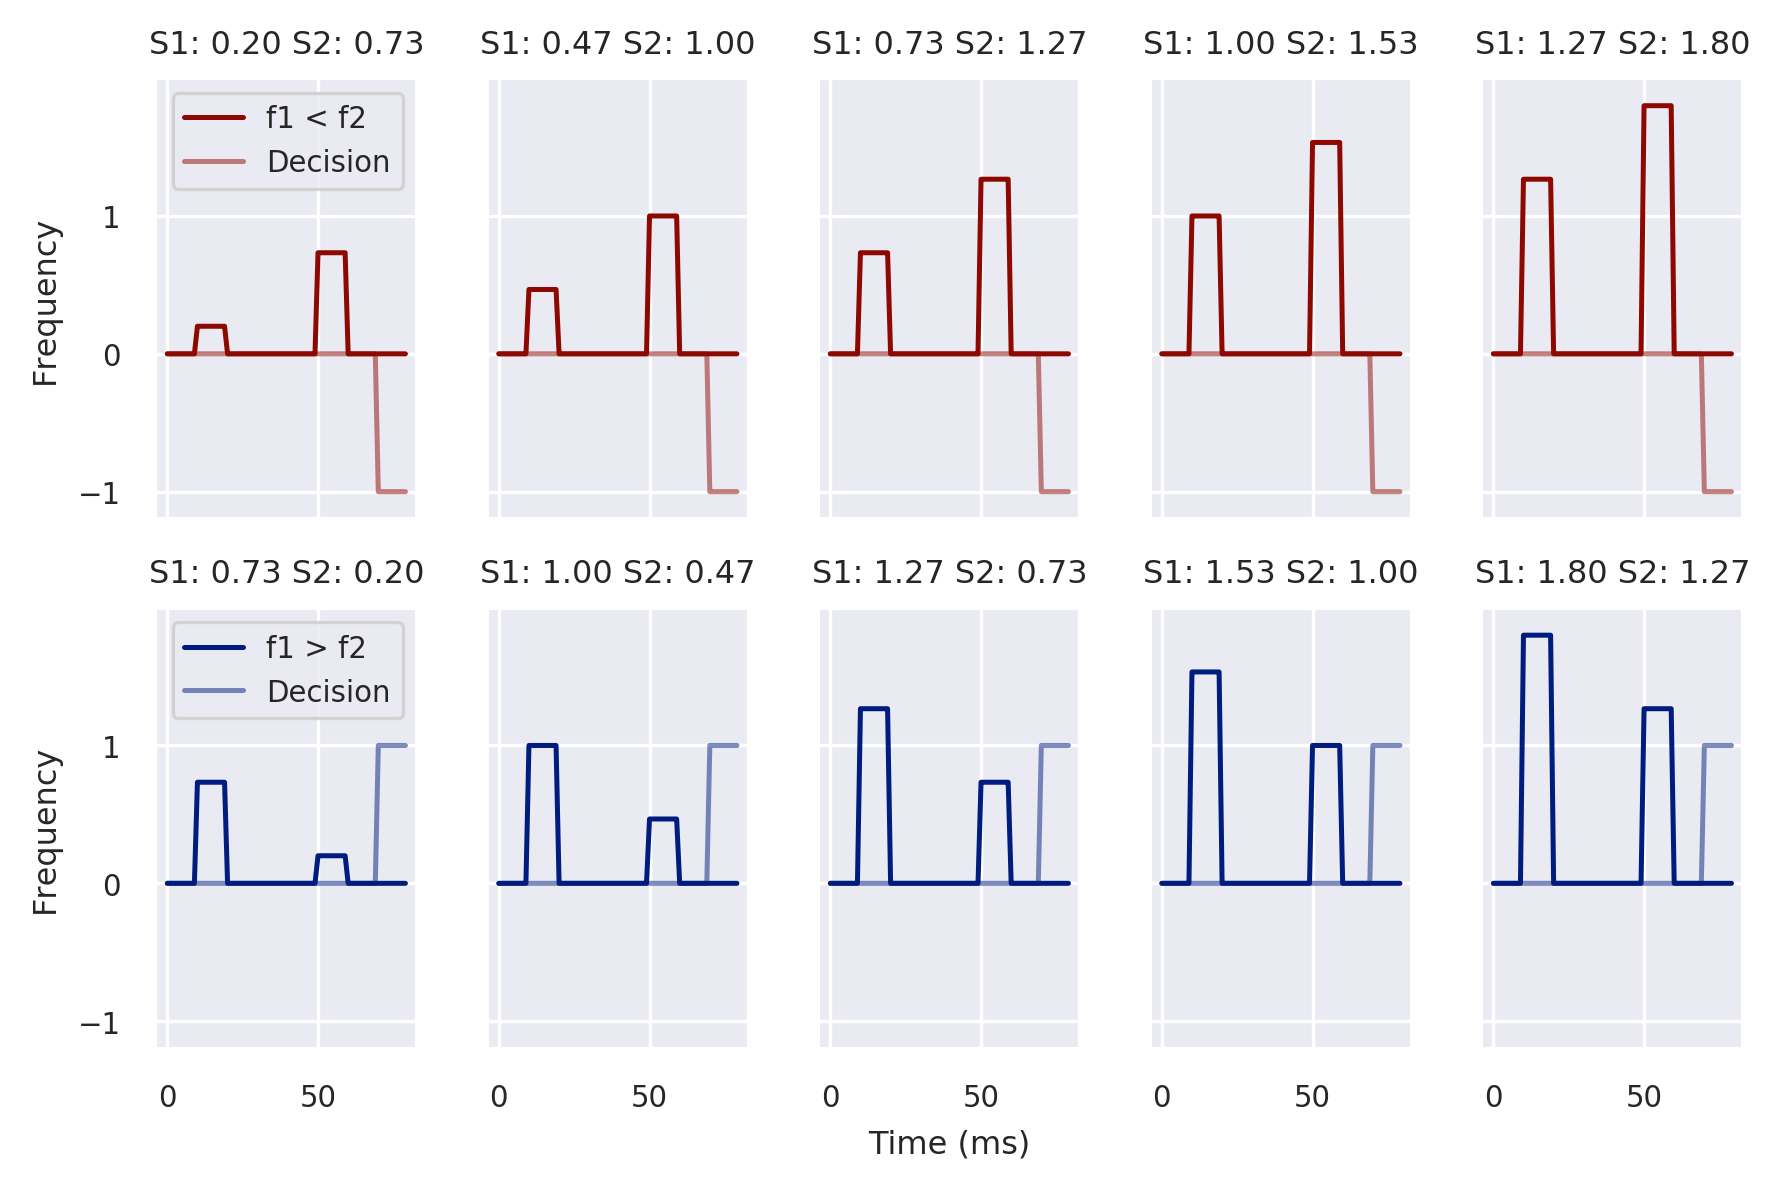

In [107]:
plot_input(2, 5, x_data, y_data)

In [570]:
rate_network = RateRNN.RateRNN(1,100,1, 60, 80, dale=True, noise_scale = 0.2)

In [571]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([rate_network.w_in, rate_network.w_rec, rate_network.w_out], lr=1e-3, betas=(0.9,0.999))
loss_hist = []

epochs = 300
for e in tqdm(range(epochs)):

    x,y = helper_funcs.create_data(rate_network.batches, rate_network.nb_steps, 0.2, 1.8, 10, 50, 10, 10)
    x_rec, r_rec, o_rec, w_rec_dale, w_out_dale, w_in  = rate_network(x)
    
    # L2 Regularization over weights.
    reg_loss = 2e-6*(0.5*(torch.sum(w_rec_dale)**2 + torch.sum(w_out_dale)**2 + torch.sum(rate_network.w_in)**2))
    
    loss = loss_fn(o_rec[:,70:], y[:,70:]) + reg_loss
    
    if e % int(epochs / 1) == 0:
        print(e+1, loss.item())
            
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())

  1%|          | 2/300 [00:00<00:22, 12.99it/s]

1 1.544253945350647


100%|██████████| 300/300 [00:16<00:00, 17.57it/s]


In [572]:
rate_weights = ({"n=100": [w_rec_dale.detach().numpy(), w_in.detach().numpy(), w_out_dale.detach().numpy()]})
with open('rate_weights.pkl', 'wb') as f:
    pickle.dump(rate_weights, f)

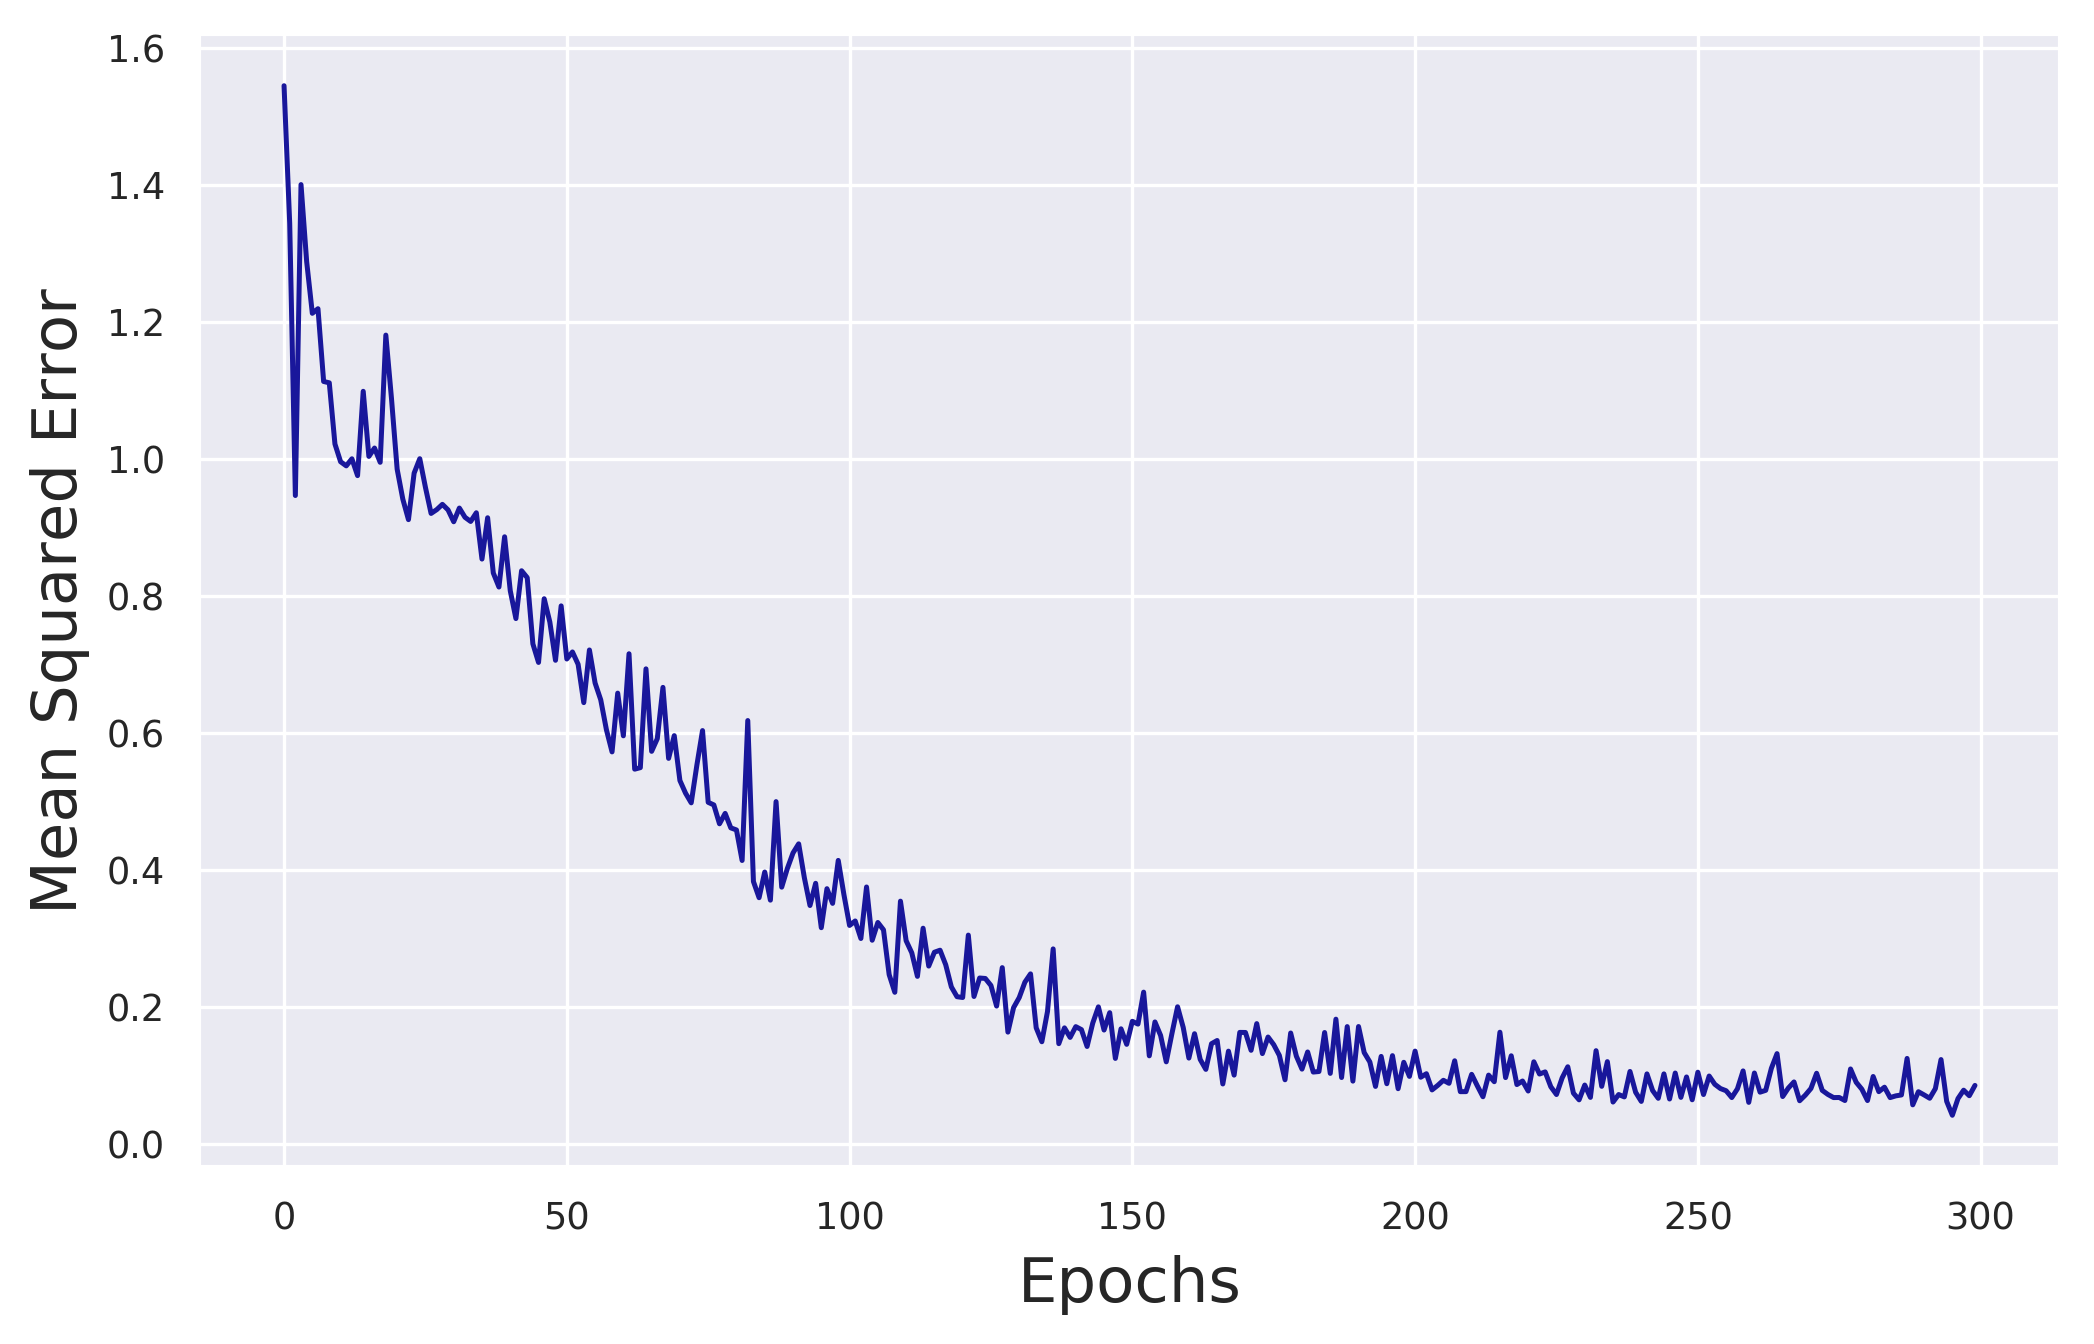

In [864]:
plt.figure(figsize = (8,5), dpi=300)
plt.plot(loss_hist, c='#19179b')
#plt.title(r"Mean Squared Error Loss", size = 15)
plt.xlabel("Epochs", size = 15)
plt.ylabel("Mean Squared Error", size = 15)
plt.savefig("train vibro-tactile", dpi=200, format="pdf")

In [574]:
x,y = helper_funcs.create_data(rate_network.batches, rate_network.nb_steps, 0.2, 1.8, 10, 50, 10, 10)
x_rec, r_rec, o_rec, _,_,_  = rate_network(x)

In [575]:
output = o_rec.detach().numpy()
y = y.detach().numpy()
x=x.detach().numpy()

In [576]:
def performance_input(r, c, x, y, output, batches, s1, s2, dec_time, top):
    performance = np.sum(np.sign(output[:,dec_time])==y[:,dec_time])/batches

    f, ax = plt.subplots(r, c, dpi=300)
    count = 0
    #plt.suptitle("Performance: %d" %np.round(100*performance,0), size= 16)
    for j in range(r):
        for i in range(c):
            plt.subplots_adjust(hspace=3)
            #ax[j,i].set_title('Label %d' %int(y[count,-1]))
            if float(x[count,s1]) > float(x[count,s2]):
                col = "b"
                ax[j,i].plot(x[count,:], c=col, label = "f1 > f2")
                ax[j,i].plot(y[count,:], c=col, alpha= 0.5, label = "Decision")
                ax[j,i].plot(output[count,:], c='k', label = "Output")
                ax[j,i].set_ylim((-2.0,2.0))
                lgd = ax[0,0].legend(bbox_to_anchor = (-0.3,1))
            elif float(x[count,s1]) < float(x[count,s2]):
                col = "r"
                ax[j,i].plot(x[count,:], c=col, label = "f1 < f2")
                ax[j,i].plot(y[count,:], c=col, alpha= 0.5, label = "Decision")
                ax[j,i].plot(output[count,:], c='k', label = "Output")
                ax[j,i].set_ylim((-2.0,2.0))
                lgd2 = ax[2,0].legend(bbox_to_anchor = (-0.3,1))    
            count+=1
    ax[2,1].set_xlabel("Time (ms)")
    ax[1,0].set_ylabel("Frequency")
    plt.tight_layout()
    #plt.subplots_adjust(top=top)
    plt.savefig("Output for Vibro-Tactile",bbox_extra_artists=(lgd, lgd2), bbox_inches='tight')
    plt.show()


In [577]:
sns.set(context='paper', palette='dark', font_scale=0.8)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


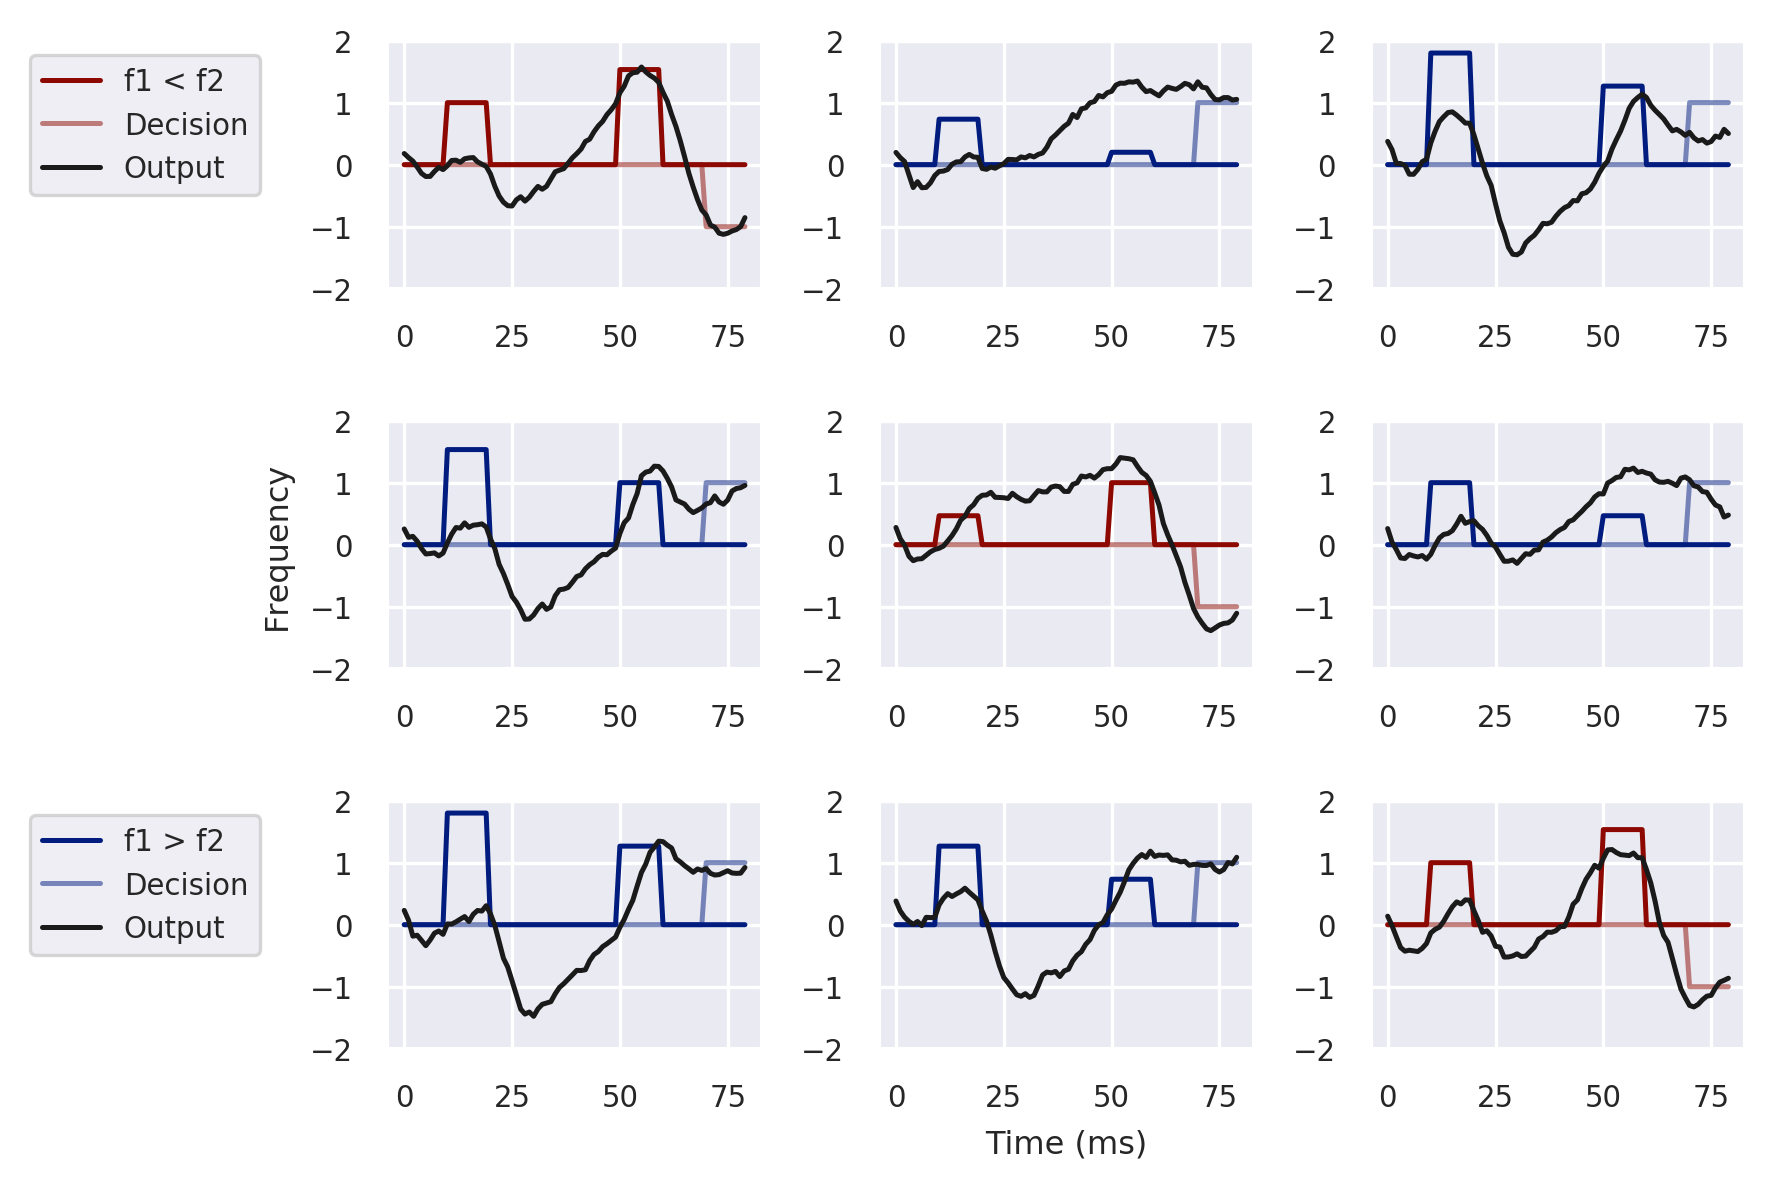

In [640]:
performance_input(3, 3, x, y, output, 60, 10, 50, 70, 0.9)

In [859]:
def output_plot(samples_yes, samples_no, avg_yes, avg_no, num):
    plt.figure(dpi=300)
    #plt.suptitle("Model Output for different trials", size = 16)
    plt.plot(avg_no, label = "Average f1<f2", linewidth=2, c ="r")
    plt.plot(avg_yes, label = "Average f1>f2", linewidth=2, c = "b")
    for i in range(num):
        plt.plot(samples_no[i+15,:],linewidth=1, alpha=0.5, c ="r")
        plt.plot(samples_yes[i+15,:],linewidth=1, alpha=0.5, c ="b")
    plt.fill_between((10,20),(-2,-2), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.fill_between((10,20),(2,2), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.fill_between((50,60),(-2,-2), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.fill_between((50,60),(2,2), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.axvline(70, color='k', linestyle=':', linewidth=1, label="Decision Cue")
    plt.axhline(0, color='k', linestyle='-', linewidth=2, label="Decision Divide")
    plt.xlabel("Time (ms)")
    plt.yticks([-2.0,-1.0,0,1.0,2.0])
    plt.ylabel("Output")
    plt.ylim(-2,2)
    
    plt.legend()
    plt.savefig("Output plot", format='pdf')
    plt.savefig("Output plot")
    plt.show()

In [850]:
out_av.detach().numpy()[np.where(y_av[:,70] == -1)[0],:].shape

(1303, 80, 1)

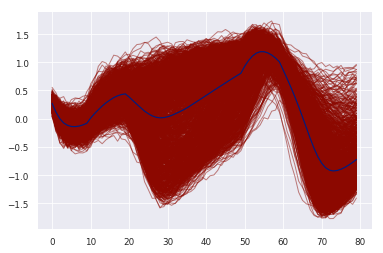

In [856]:
for i in range(samples_no.shape[0]):
    plt.plot(samples_no[i,:],linewidth=1, alpha=0.5, c ="r")
plt.plot(no_res)
plt.show()

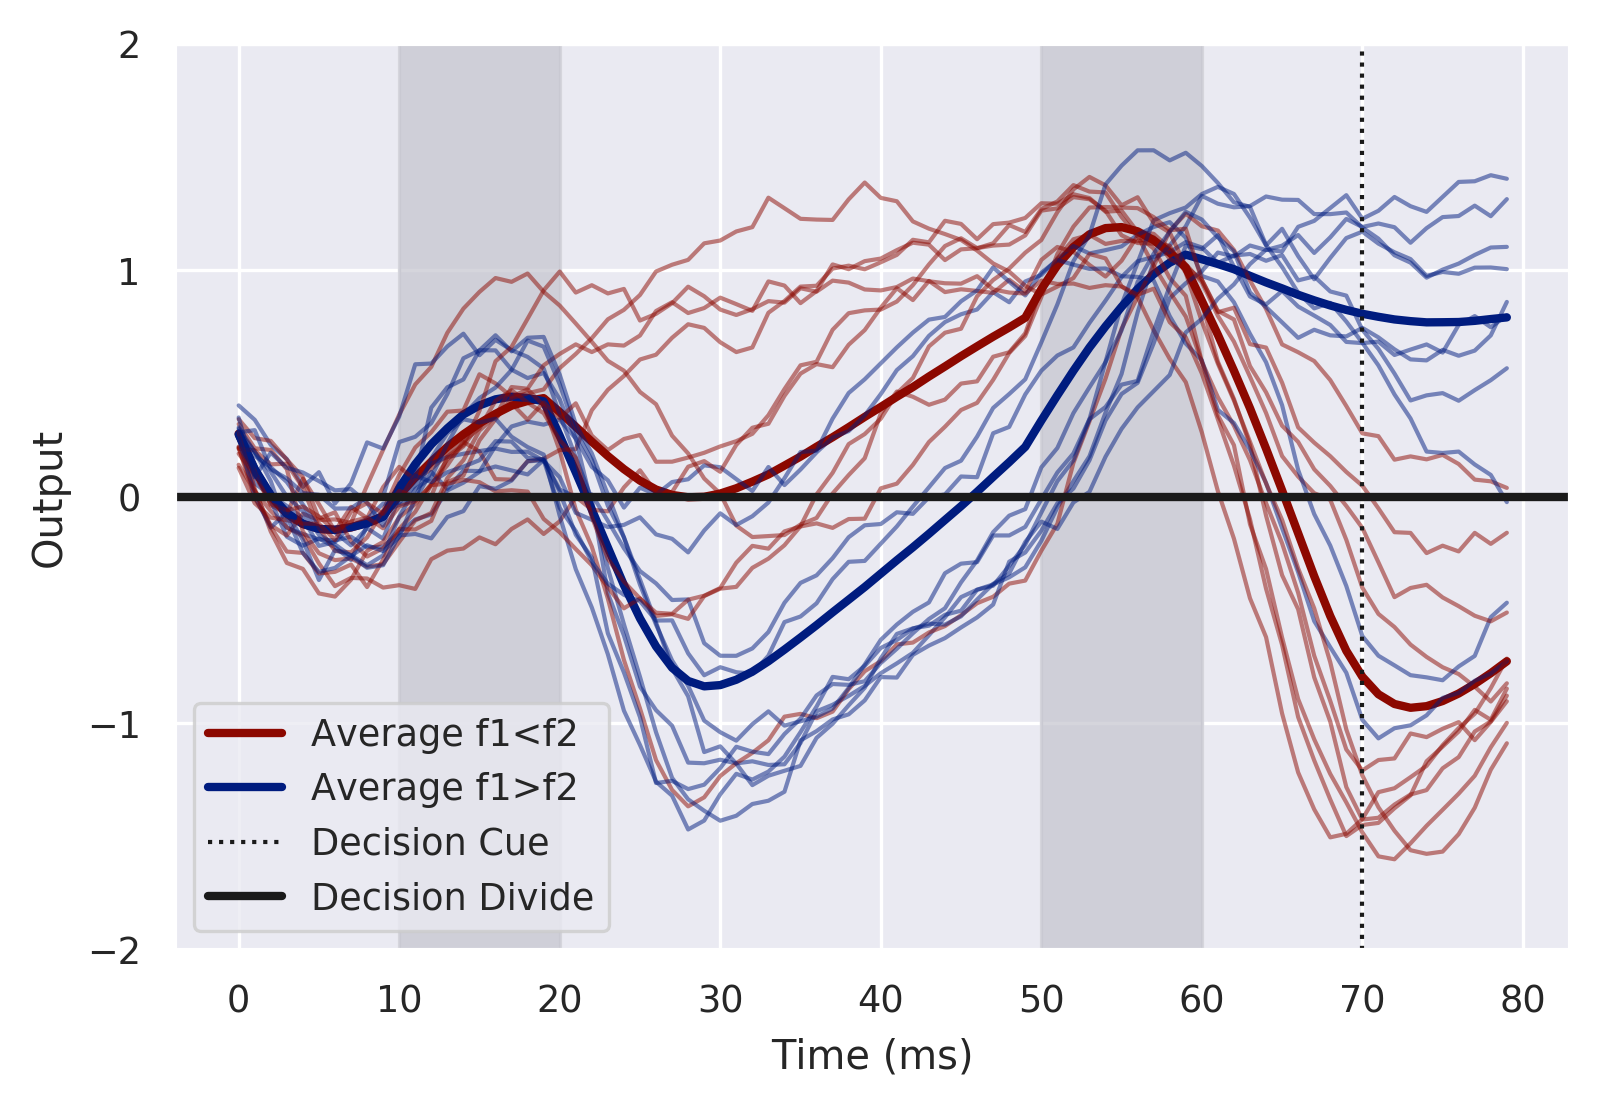

In [861]:
x_av, y_av = helper_funcs.model_output(2592, 80, 0.2, 1.8, 10, 50, 10, 10)
_,_,out_av, _, _,_ = rate_network(x_av)

samples_no = out_av.detach().numpy()[np.where(y_av[:,70] == -1)[0],:]
samples_yes = out_av.detach().numpy()[np.where(y_av[:,70] == 1)[0],:]
no_res = samples_no.mean(0)
yes_res = samples_yes.mean(0)

output_plot(samples_yes, samples_no, yes_res, no_res,10)

In [581]:
f_range= np.linspace(0.2,1.8,7)
xf, yf = helper_funcs.create_data_nonrandom(100, 80, 0.2, 1.8, 10, 50, 10, 10)
x_freq,rec_freq, out_freq, w_freq,_,_ = rate_network(xf)

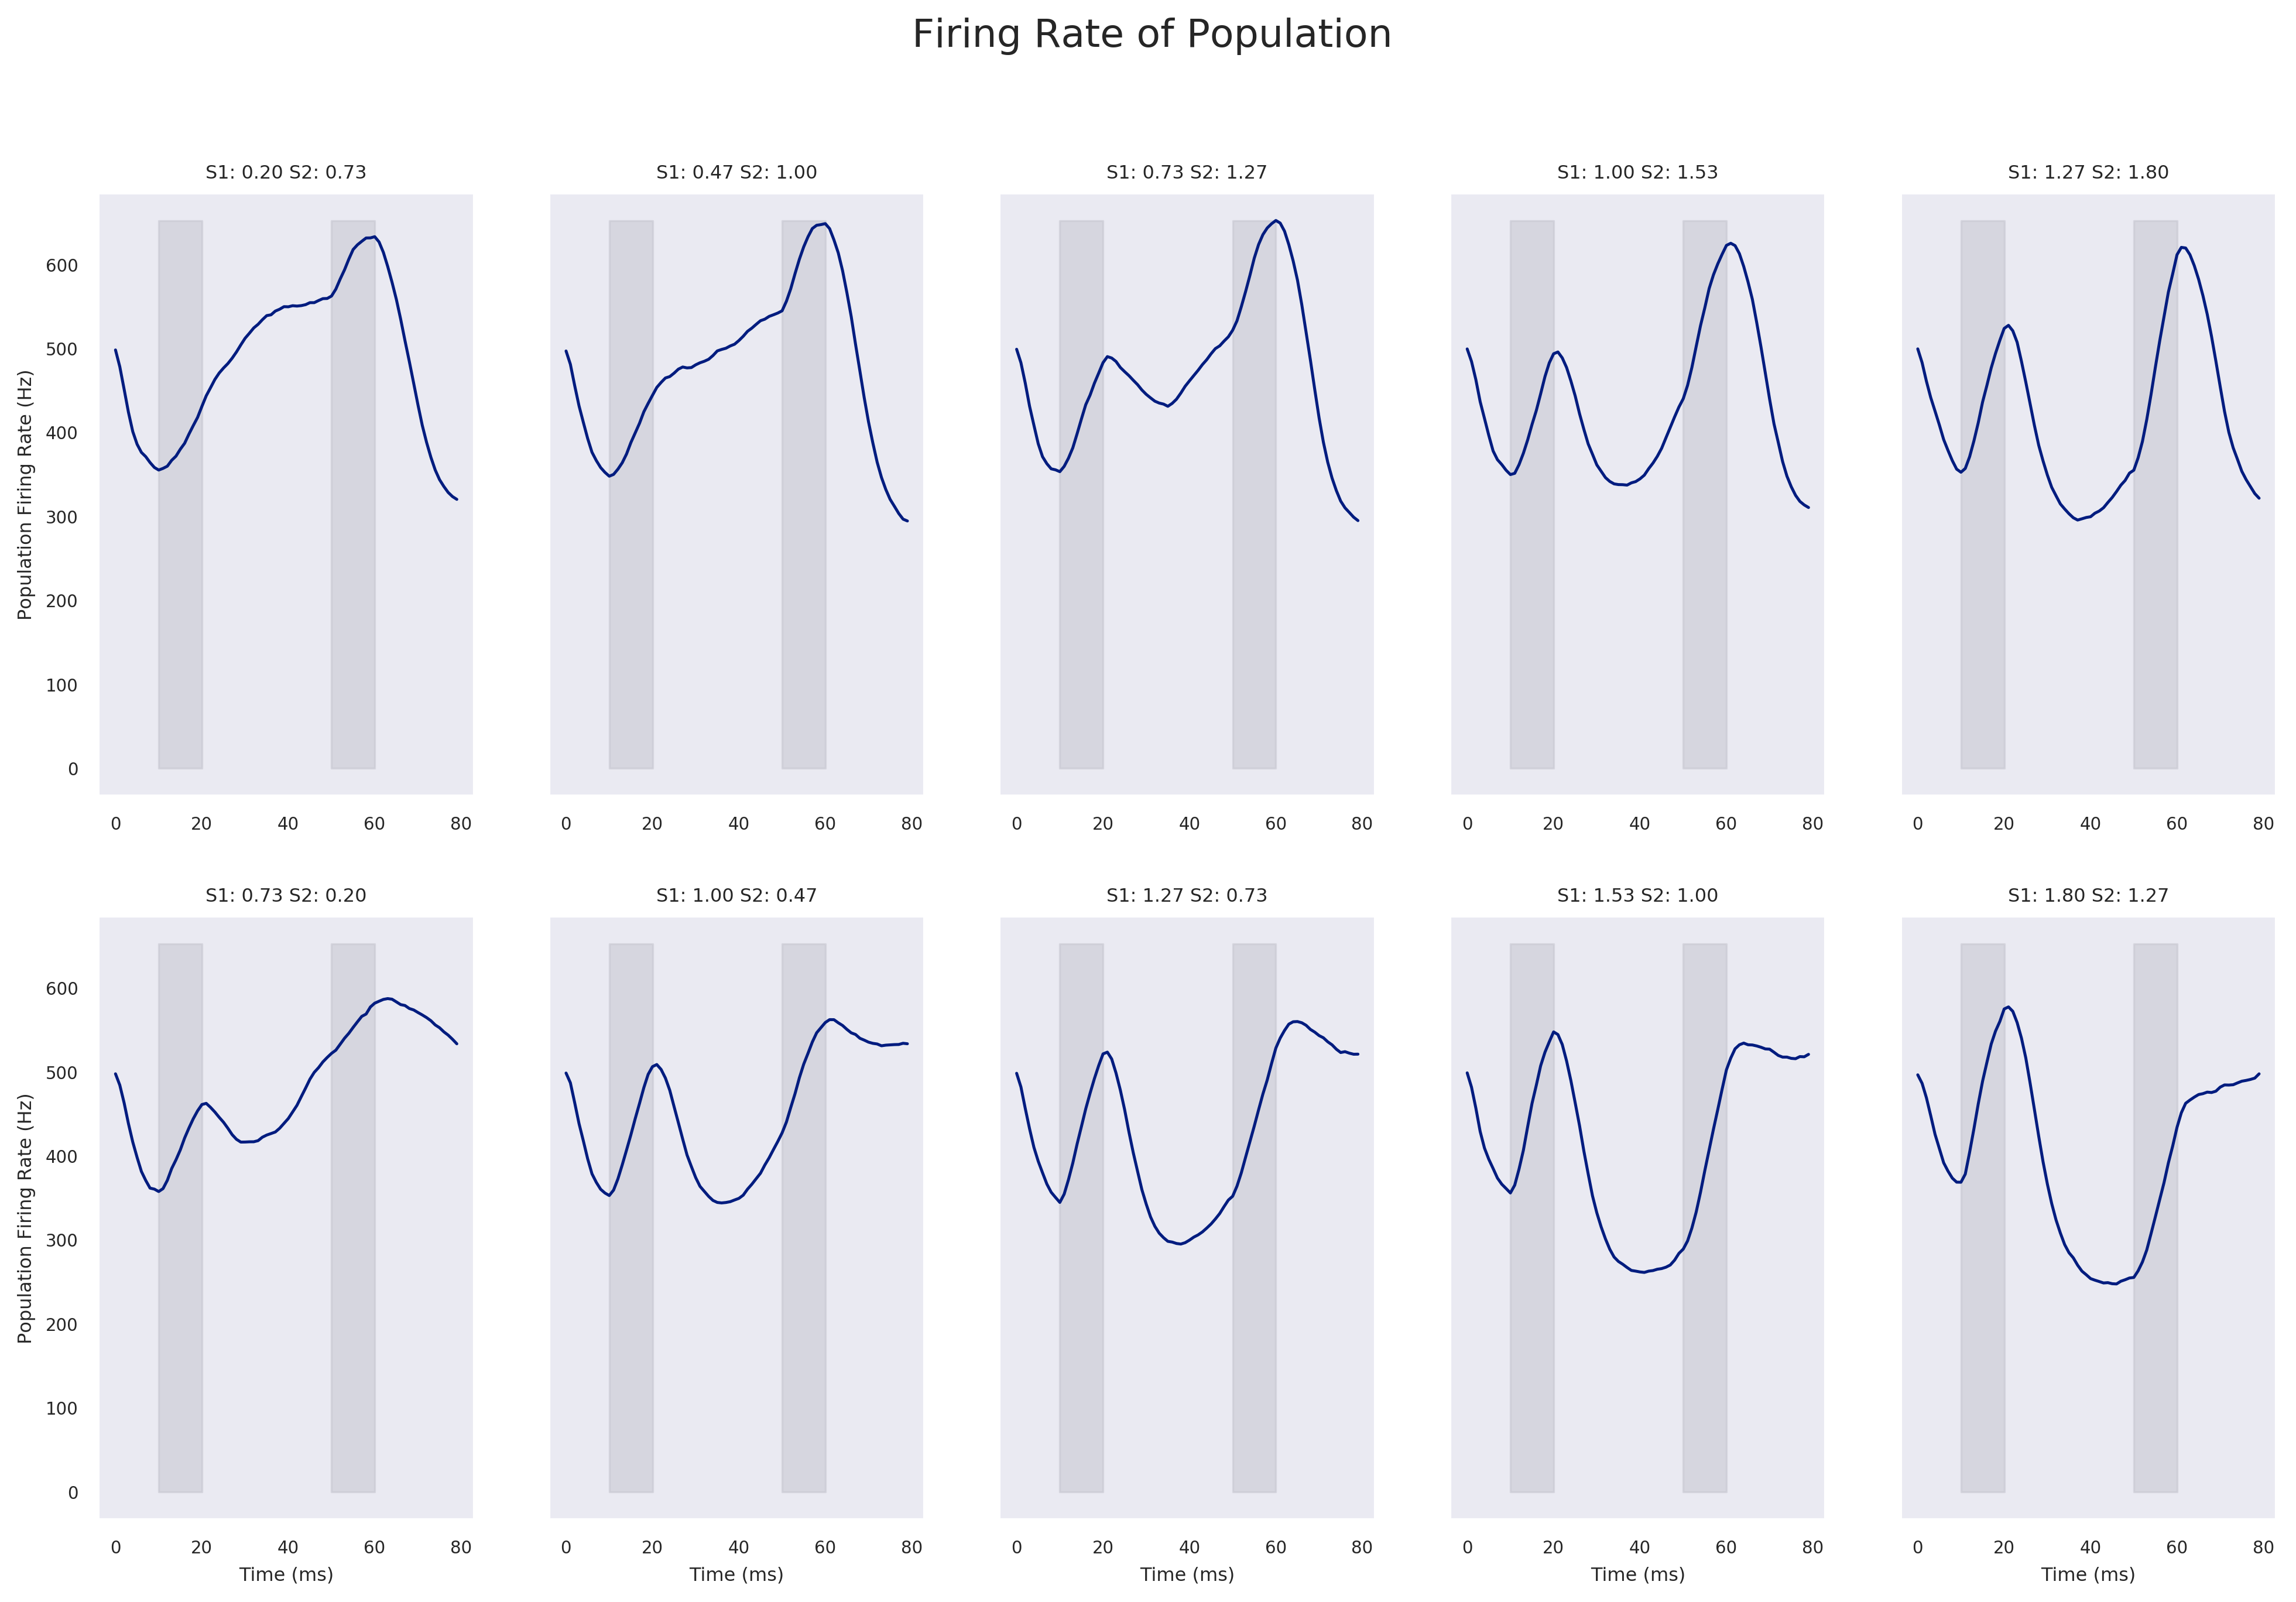

In [582]:
plotting_helper.freq_stim(2,5,rec_freq.detach().numpy(),xf,15,55)

In [679]:
sns.set(context='paper', palette='dark', font_scale=1.4)

In [584]:
colors = pl.cm.jet(np.linspace(0,1,7))

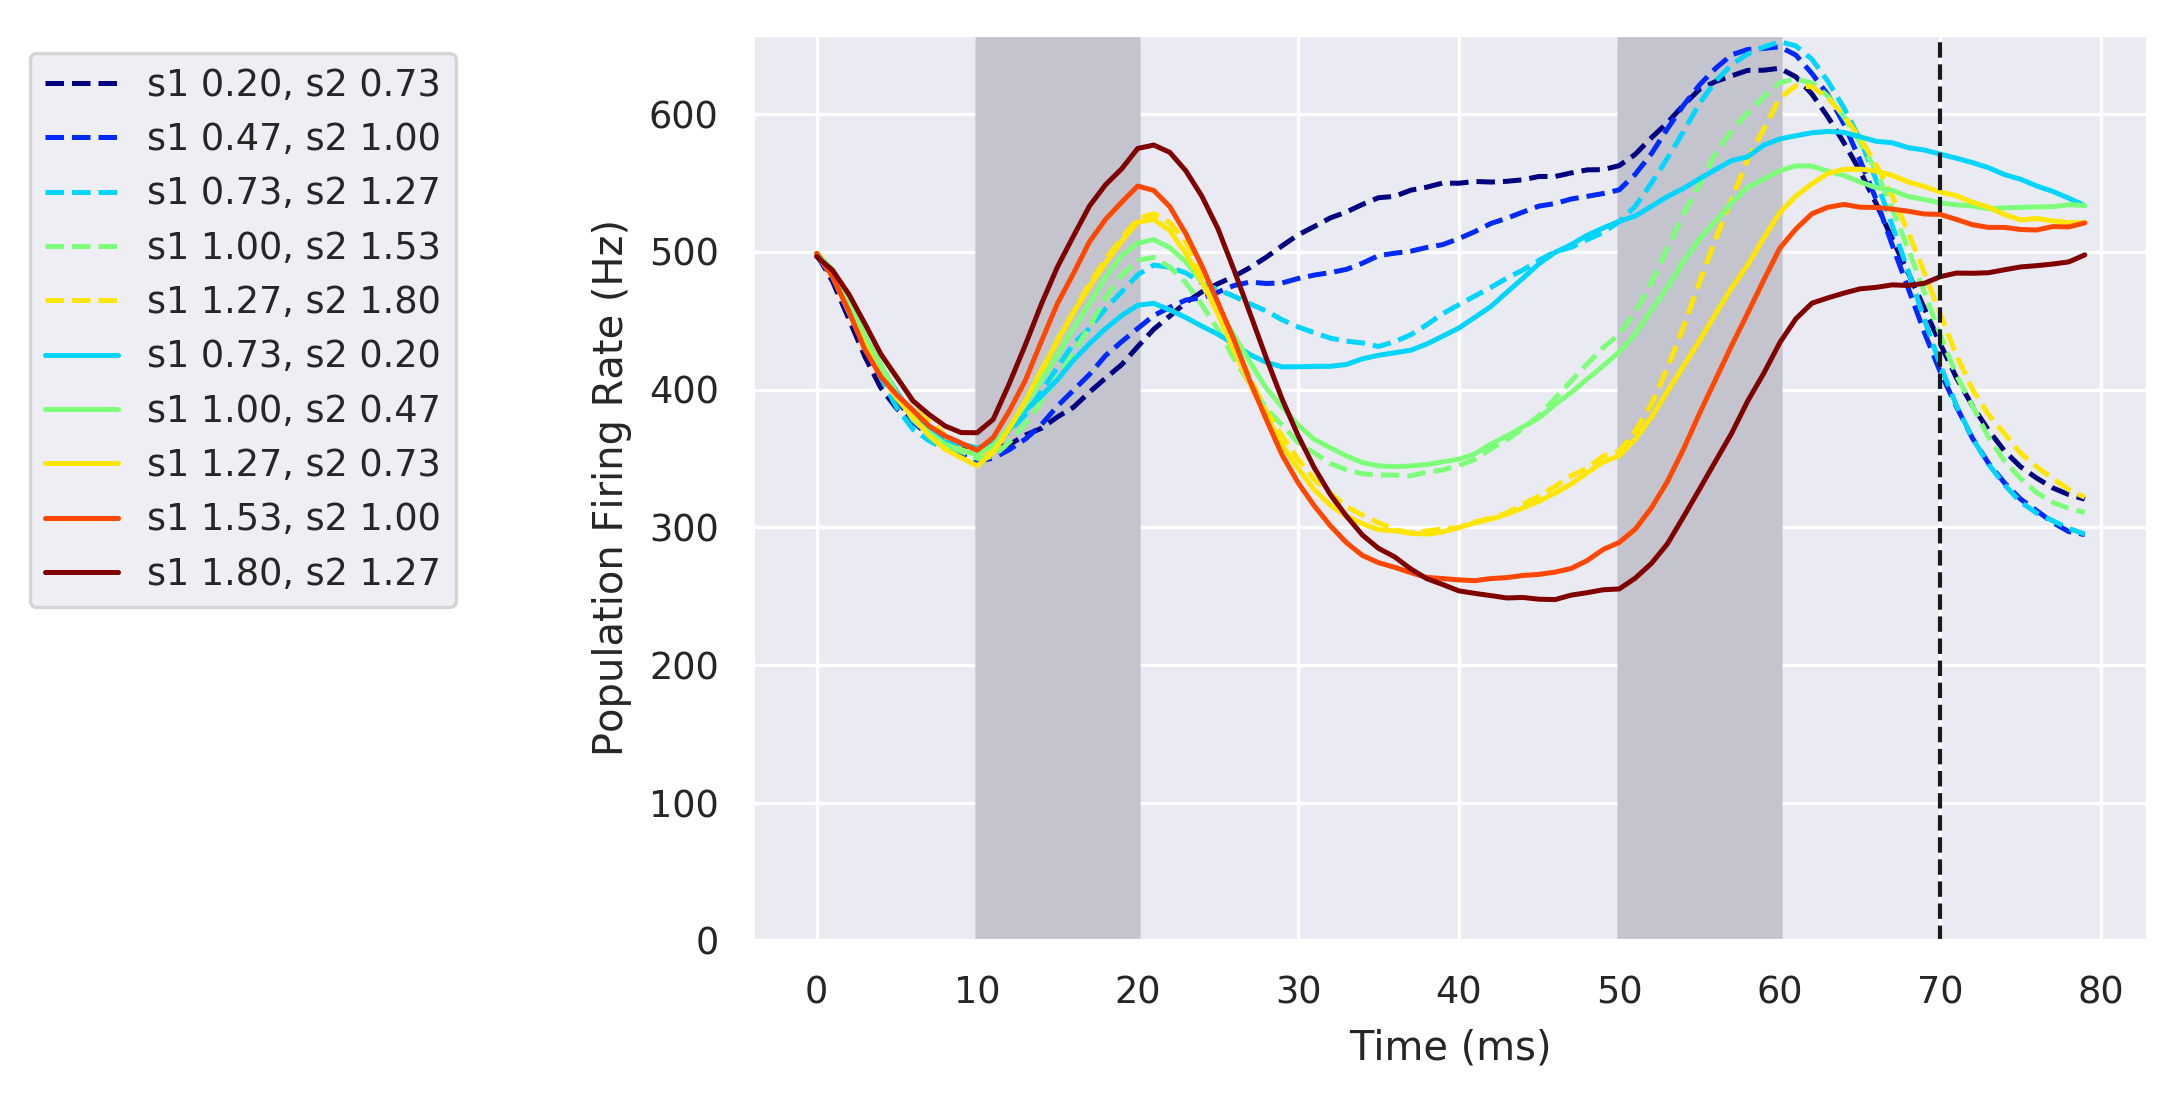

In [739]:

pop_rate = np.asarray([rec_freq.detach().numpy()[count*10:(count+1)*10,:,:].mean(0).mean(1) for count in range(10)])*1000
plt.figure(dpi=300)
count=0
for i in range(pop_rate.shape[0]-5):
    plt.plot(pop_rate[i].T, c=colors[count], linestyle='--', label = "s1 %.2f, s2 %.2f" %(np.round(xf[count*10,15],2),np.round(xf[count*10,55],2)))
    plt.fill_between((10,20),(np.max(pop_rate)+5,np.max(pop_rate)+5), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.fill_between((50,60),(np.max(pop_rate)+5,np.max(pop_rate)+5), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    count+=1
    
count2=0
for j in range(pop_rate.shape[0]-5):
    plt.plot(pop_rate[j+5].T, c=colors[count2+2], label = "s1 %.2f, s2 %.2f" %(np.round(xf[(count2)*10+50,15],2),np.round(xf[(count2)*10+50,55],2)))
    plt.fill_between((10,20),(np.max(pop_rate),np.max(pop_rate)), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.fill_between((50,60),(np.max(pop_rate),np.max(pop_rate)), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    count2+=1
    lgd = plt.legend(bbox_to_anchor = (-0.2,1))
plt.axvline(70, color='k', linestyle='--', linewidth=1, label="decision")
plt.ylim(0,np.max(pop_rate)+5)
plt.xlabel("Time (ms)")
plt.ylabel("Population Firing Rate (Hz)")
#plt.text(-60,-80, "B", size=16)
#plt.title("Population activity for stimulus pairs", size = 16)
plt.savefig("Population activity comparison",bbox_extra_artists=(lgd,), bbox_inches='tight', format="pdf")
plt.savefig("Population activity comparison",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [586]:
# colors = pl.cm.jet(np.linspace(0,1,10))
# pop_rate = np.asarray([rec_freq.detach().numpy()[count*10:(count+1)*10,:,:].mean(0).mean(1) for count in range(10)])*1000
# f = plt.figure(figsize = (12,8), dpi=300)
# count=0
# ax1  = f.add_axes([0.10,0.10,0.70,0.85])
# for i in range(colors.shape[0]):
#     ax1.plot(pop_rate[i].T, c=colors[count], label = "s1 %.2f, s2 %.2f" %(np.round(xf[count*10,15],2),np.round(xf[count*10,55],2)))
#     ax1.fill_between((10,20),(600,600), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
#     ax1.fill_between((50,60),(600,600), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
#     count+=1
#     lgd = ax1.legend(bbox_to_anchor = (-0.1,1))
# ax1.axvline(70, color='k', linestyle='--', linewidth=1, label="decision")
# plt.xlabel("Time (ms)")
# plt.ylabel("Population Firing Rate (Hz)")
# plt.title("Population activity for stimulus pairs", size = 16)

# ax2  = f.add_axes([0.85,0.10,0.05,0.85])
# norm = mpl.colors.Normalize(vmin=0.2,vmax=1.8)
# cb1  = mpl.colorbar.ColorbarBase(ax2,cmap=pl.cm.jet,norm=norm,orientation='vertical')
# #plt.savefig("Population activity comparison",bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()

In [753]:
def tuning_calc(out_dyn, data, steps, nb_rec, f_range, tune_time):
    """
    Func: Calculates the tuning of neurons in relation to stimulus at time=tune_time
    
    Input: out_dyn, data, steps, f_range, tune_time
        
    Return: slopes, frac_sig
    """
    
    freq_tune = np.empty((len(f_range), steps, nb_rec))
    for j in range(nb_rec):
        for i,k in enumerate(f_range):
            f_test = np.where(data[:,tune_time,:] == k)[0]
            freq_tune[i,:,j] = out_dyn.detach().numpy()[f_test,:,j].mean(axis=0)
    error = np.empty((steps,nb_rec))
    slopes = np.empty((steps,nb_rec,4))
    for j in range(nb_rec):
        for i in range(steps):
            slopes[i,j,0], slopes[i,j,1],slopes[i,j,3], slopes[i,j,2], error[i,j] = linregress((f_range, freq_tune[:,i,j]))
            
    sig_p = np.sort(np.hstack((np.array([np.where(slopes[:,i,2]<0.05)[0] for i in range(nb_rec)]))))
    frac_sig = np.array([np.sum(sig_p==i)/nb_rec for i in range(steps)])
    return slopes, frac_sig, error

In [588]:
def tuning_percentage(frac_sig_tuned, title, s1,s2,dur, dec_time, tune_time, error):
    plt.figure( dpi=300)
    plt.title(title, size=16)
    if error==True:
        std = [frac_sig_tuned.mean(0) - np.std(frac_sig_tuned, axis=0), frac_sig_tuned.mean(0)+np.std(frac_sig_tuned, axis=0)]
        plt.fill_between(np.linspace(0,80,80), std[0],std[1], alpha=0.2)
        plt.plot(frac_sig_tuned.mean(0), label="Fraction of Neurons")
    else:
        plt.plot(frac_sig_tuned, label="Fraction of Neurons")
    plt.fill_between((s1,s1+dur),(1.0,1.0), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True, label="Stim1, Stim2")
    plt.fill_between((s2,s2+dur),(1.0,1.0), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    plt.axvline(dec_time, color='k', linestyle=':', linewidth=1, label="Decision 10 ms Delay")
    plt.axvline(tune_time, color='k', linestyle='-.', linewidth=1, label="Tuned Time")
    plt.legend(loc=2)
    plt.xlabel("Time (ms)")
    plt.ylabel("Fraction of Significantly Tuned a1")
    plt.savefig(title)
    plt.show()

In [783]:
f_range

array([0.2       , 0.46666667, 0.73333333, 1.        , 1.26666667,
       1.53333333, 1.8       ])

In [785]:
r = np.linspace(0.2,1.8, 79)
freq_tune = np.empty((len(f_range), 80,100))
for j in range(100):
    for i,k in enumerate(f_range):
        f_test = np.where(xf[:,15,:] == k)[0]
        freq_tune[i,:,j] = rec_freq.detach().numpy()[f_test,:,j].mean(0)*1000

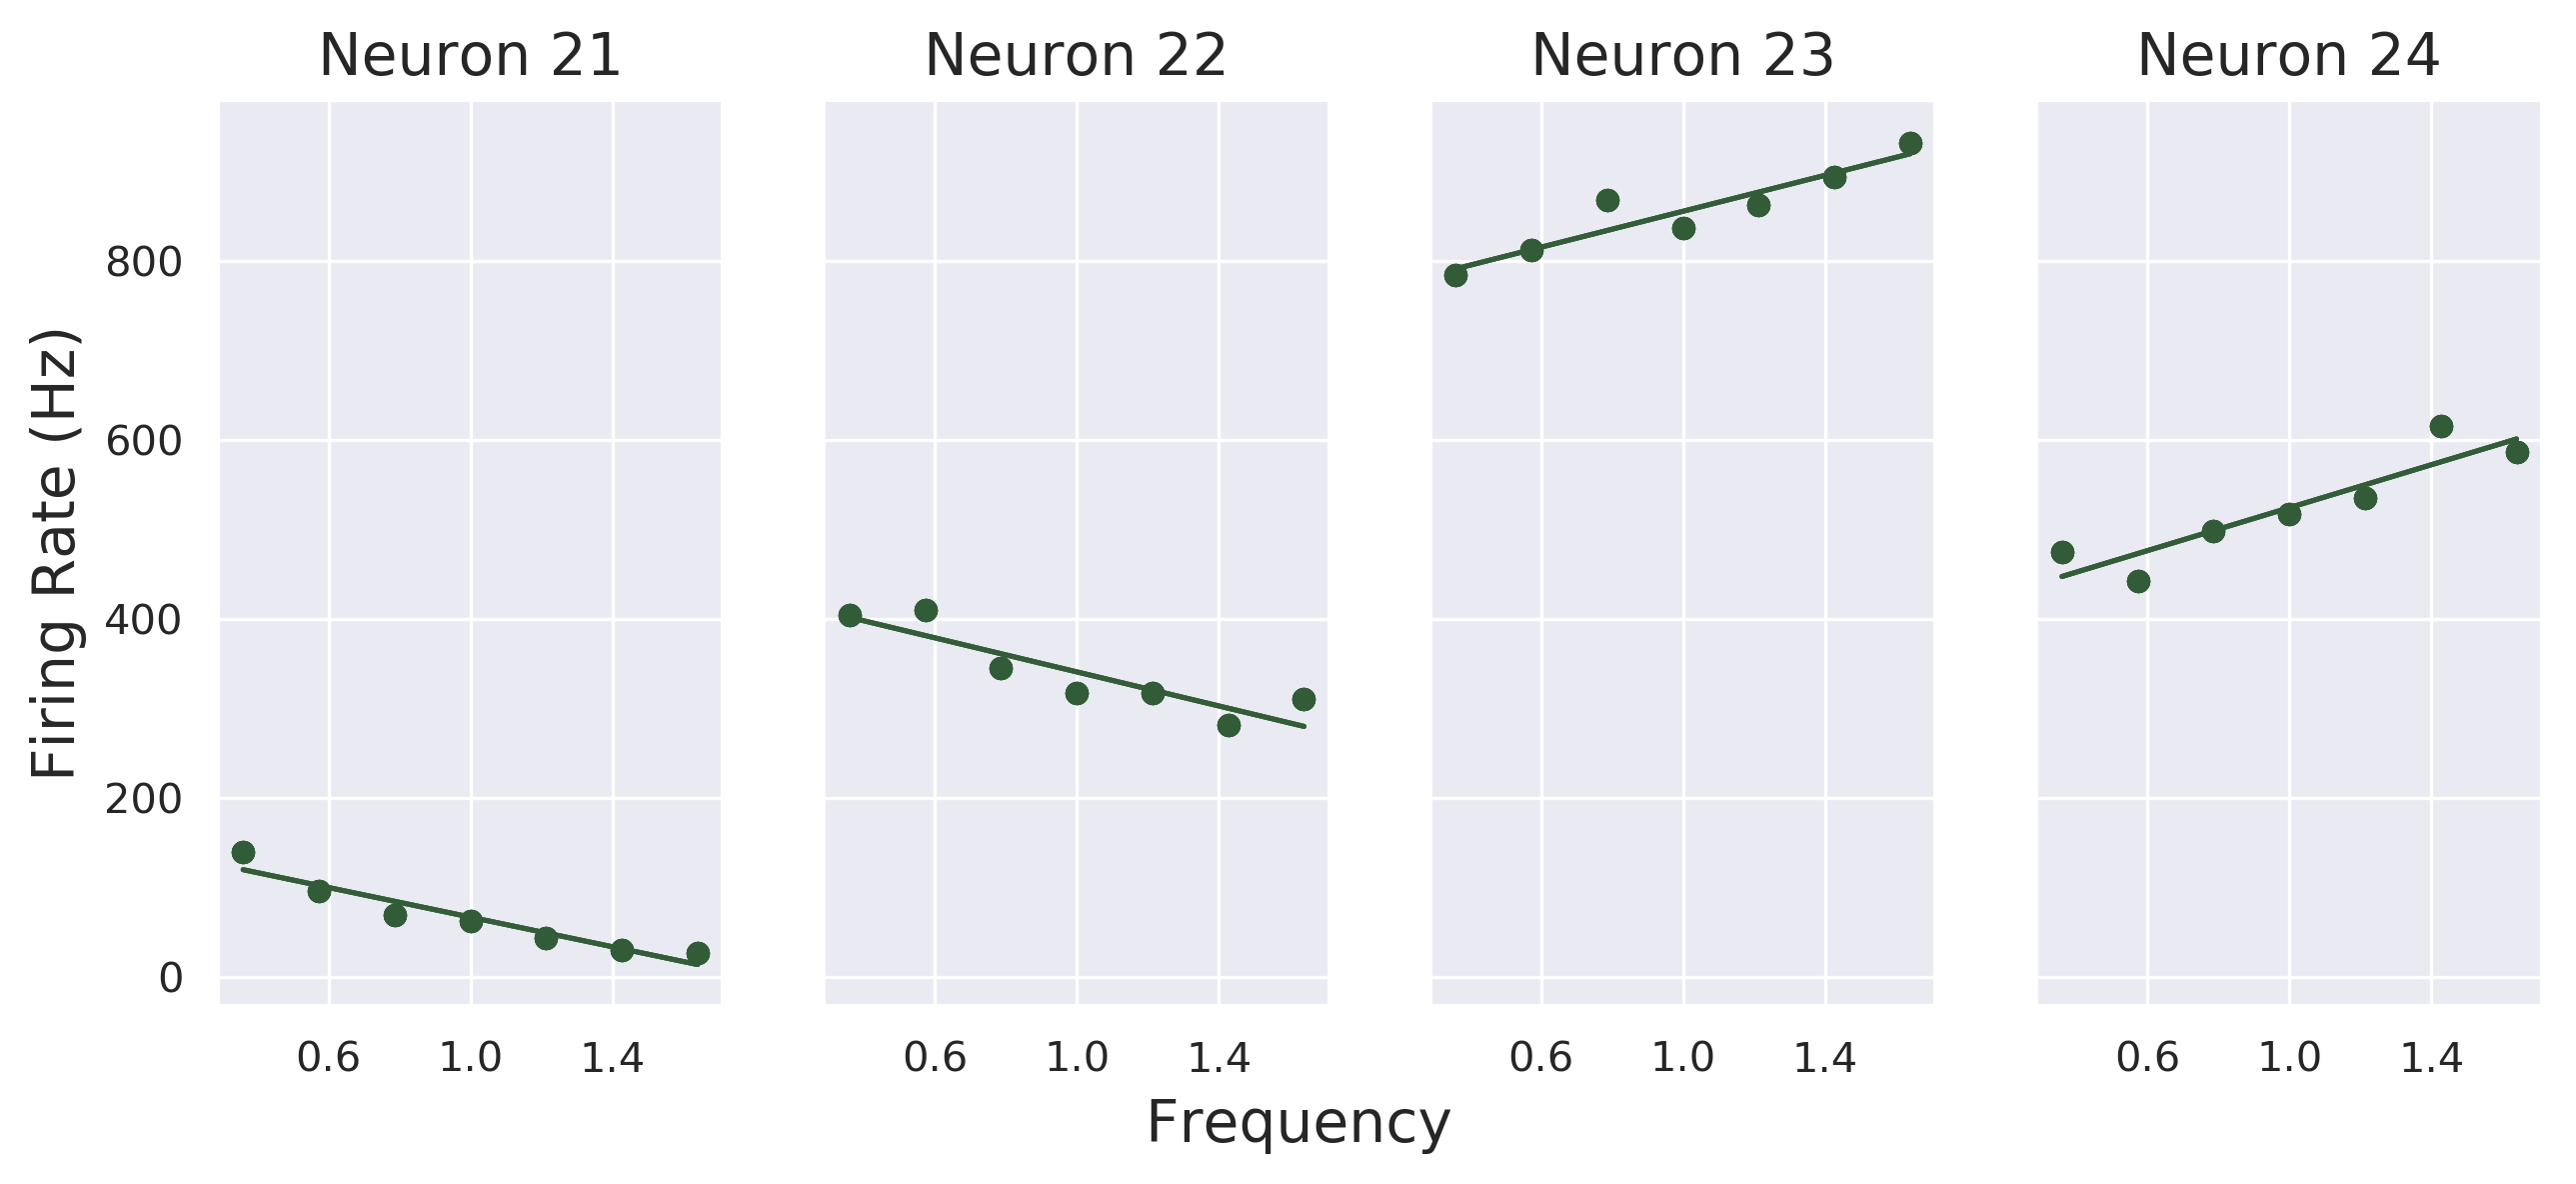

In [801]:
f, ax = plt.subplots(1, 4, figsize=(10,4), sharey=True, dpi=300)
times =[15,45,65,70]

#plt.suptitle("Linear Regression Fit to Firing Rates for Frequencies")
for j,k in enumerate(tuned_neurons[15:19]):
    count=0
    for i in times:
        ax[j].set_title("Neuron %d" %(k), size=14)
        ax[j].plot(r, slopes[15,k,0]*r*1000+slopes[15,k,1]*1000, alpha=0.7, c = '#325c37', label="Linear Regression Fit")
        ax[j].scatter(f_range,freq_tune[:,15,k], c = "#325c37", label = "Firing Rates")
        ax[j].set_xticklabels([])
        ax[j].set_xticklabels([0.2,0.6, 1. , 1.4], size=10)
        ax[j].tick_params(labelsize=10)
        count+=1
plt.yticks(size=10)
ax[0].set_ylabel("Firing Rate (Hz)", size=14)
ax[1].set_xlabel("                        Frequency", size=14)
#ax[0].set_yticks(size=12)
#box = ax[0,2].get_position()
#ax[0,2].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis

#ax[0,2].legend(loc='upper center', bbox_to_anchor=(-0.3, 1.55),fancybox=True, ncol=2)
plt.savefig("Investigating Linear Regression")
plt.savefig("Investigating Linear Regression", format="pdf")
plt.show()

In [779]:
error.mean()

0.028102947401305676

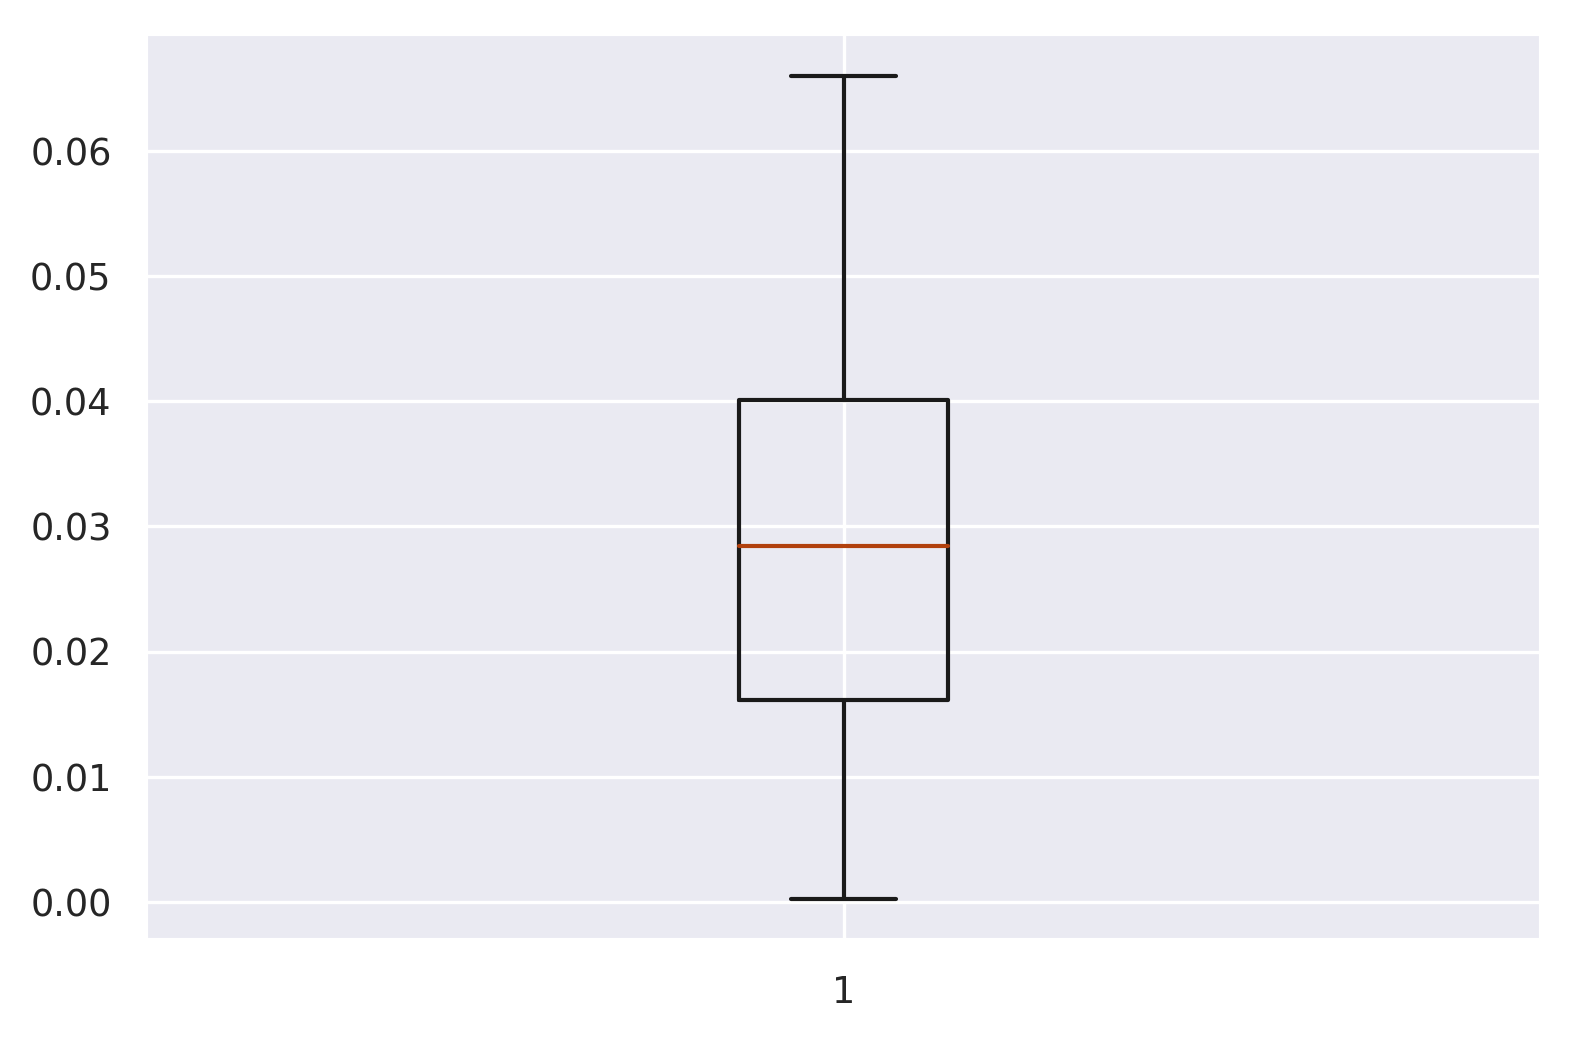

In [767]:
plt.figure(dpi=300)
plt.boxplot(error.mean(0))
plt.show()

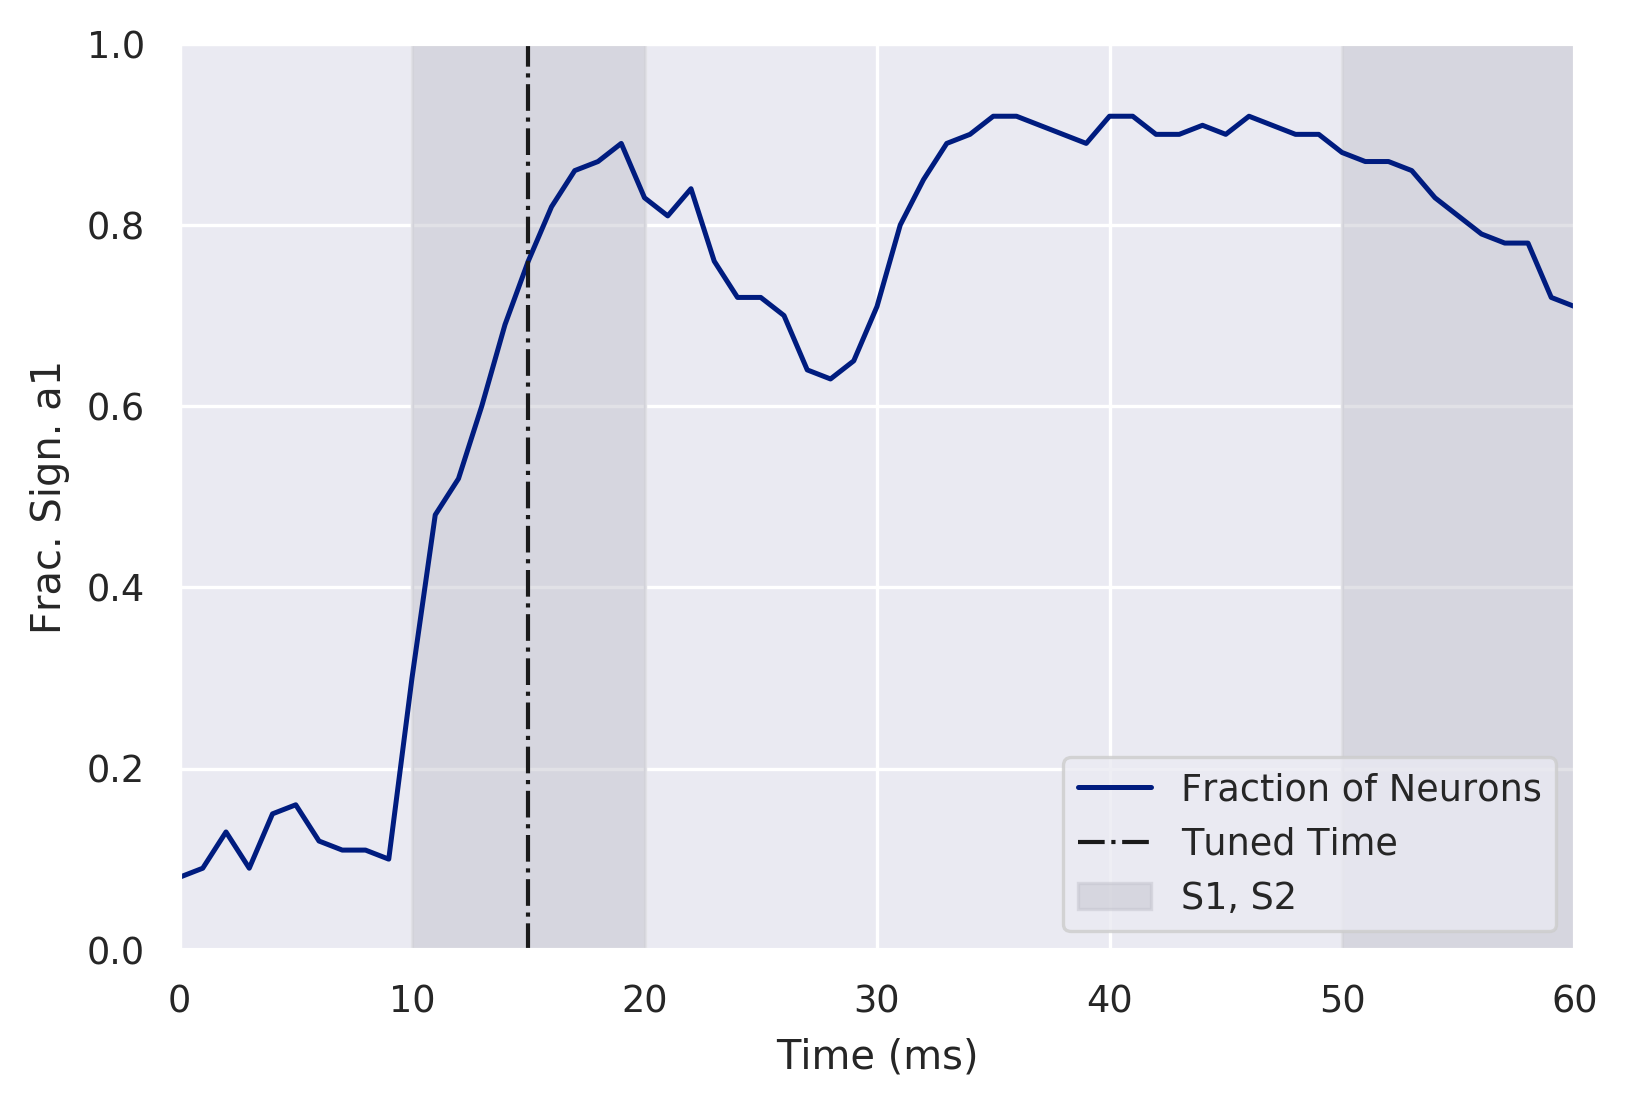

In [754]:
slopes, frac_tune, error = tuning_calc(rec_freq, xf, 80, 100, f_range, 15)
tuning_percentage(frac_tune, "Fraction Tuned to Stim1", 10, 50, 10, 70, 15, error=False)

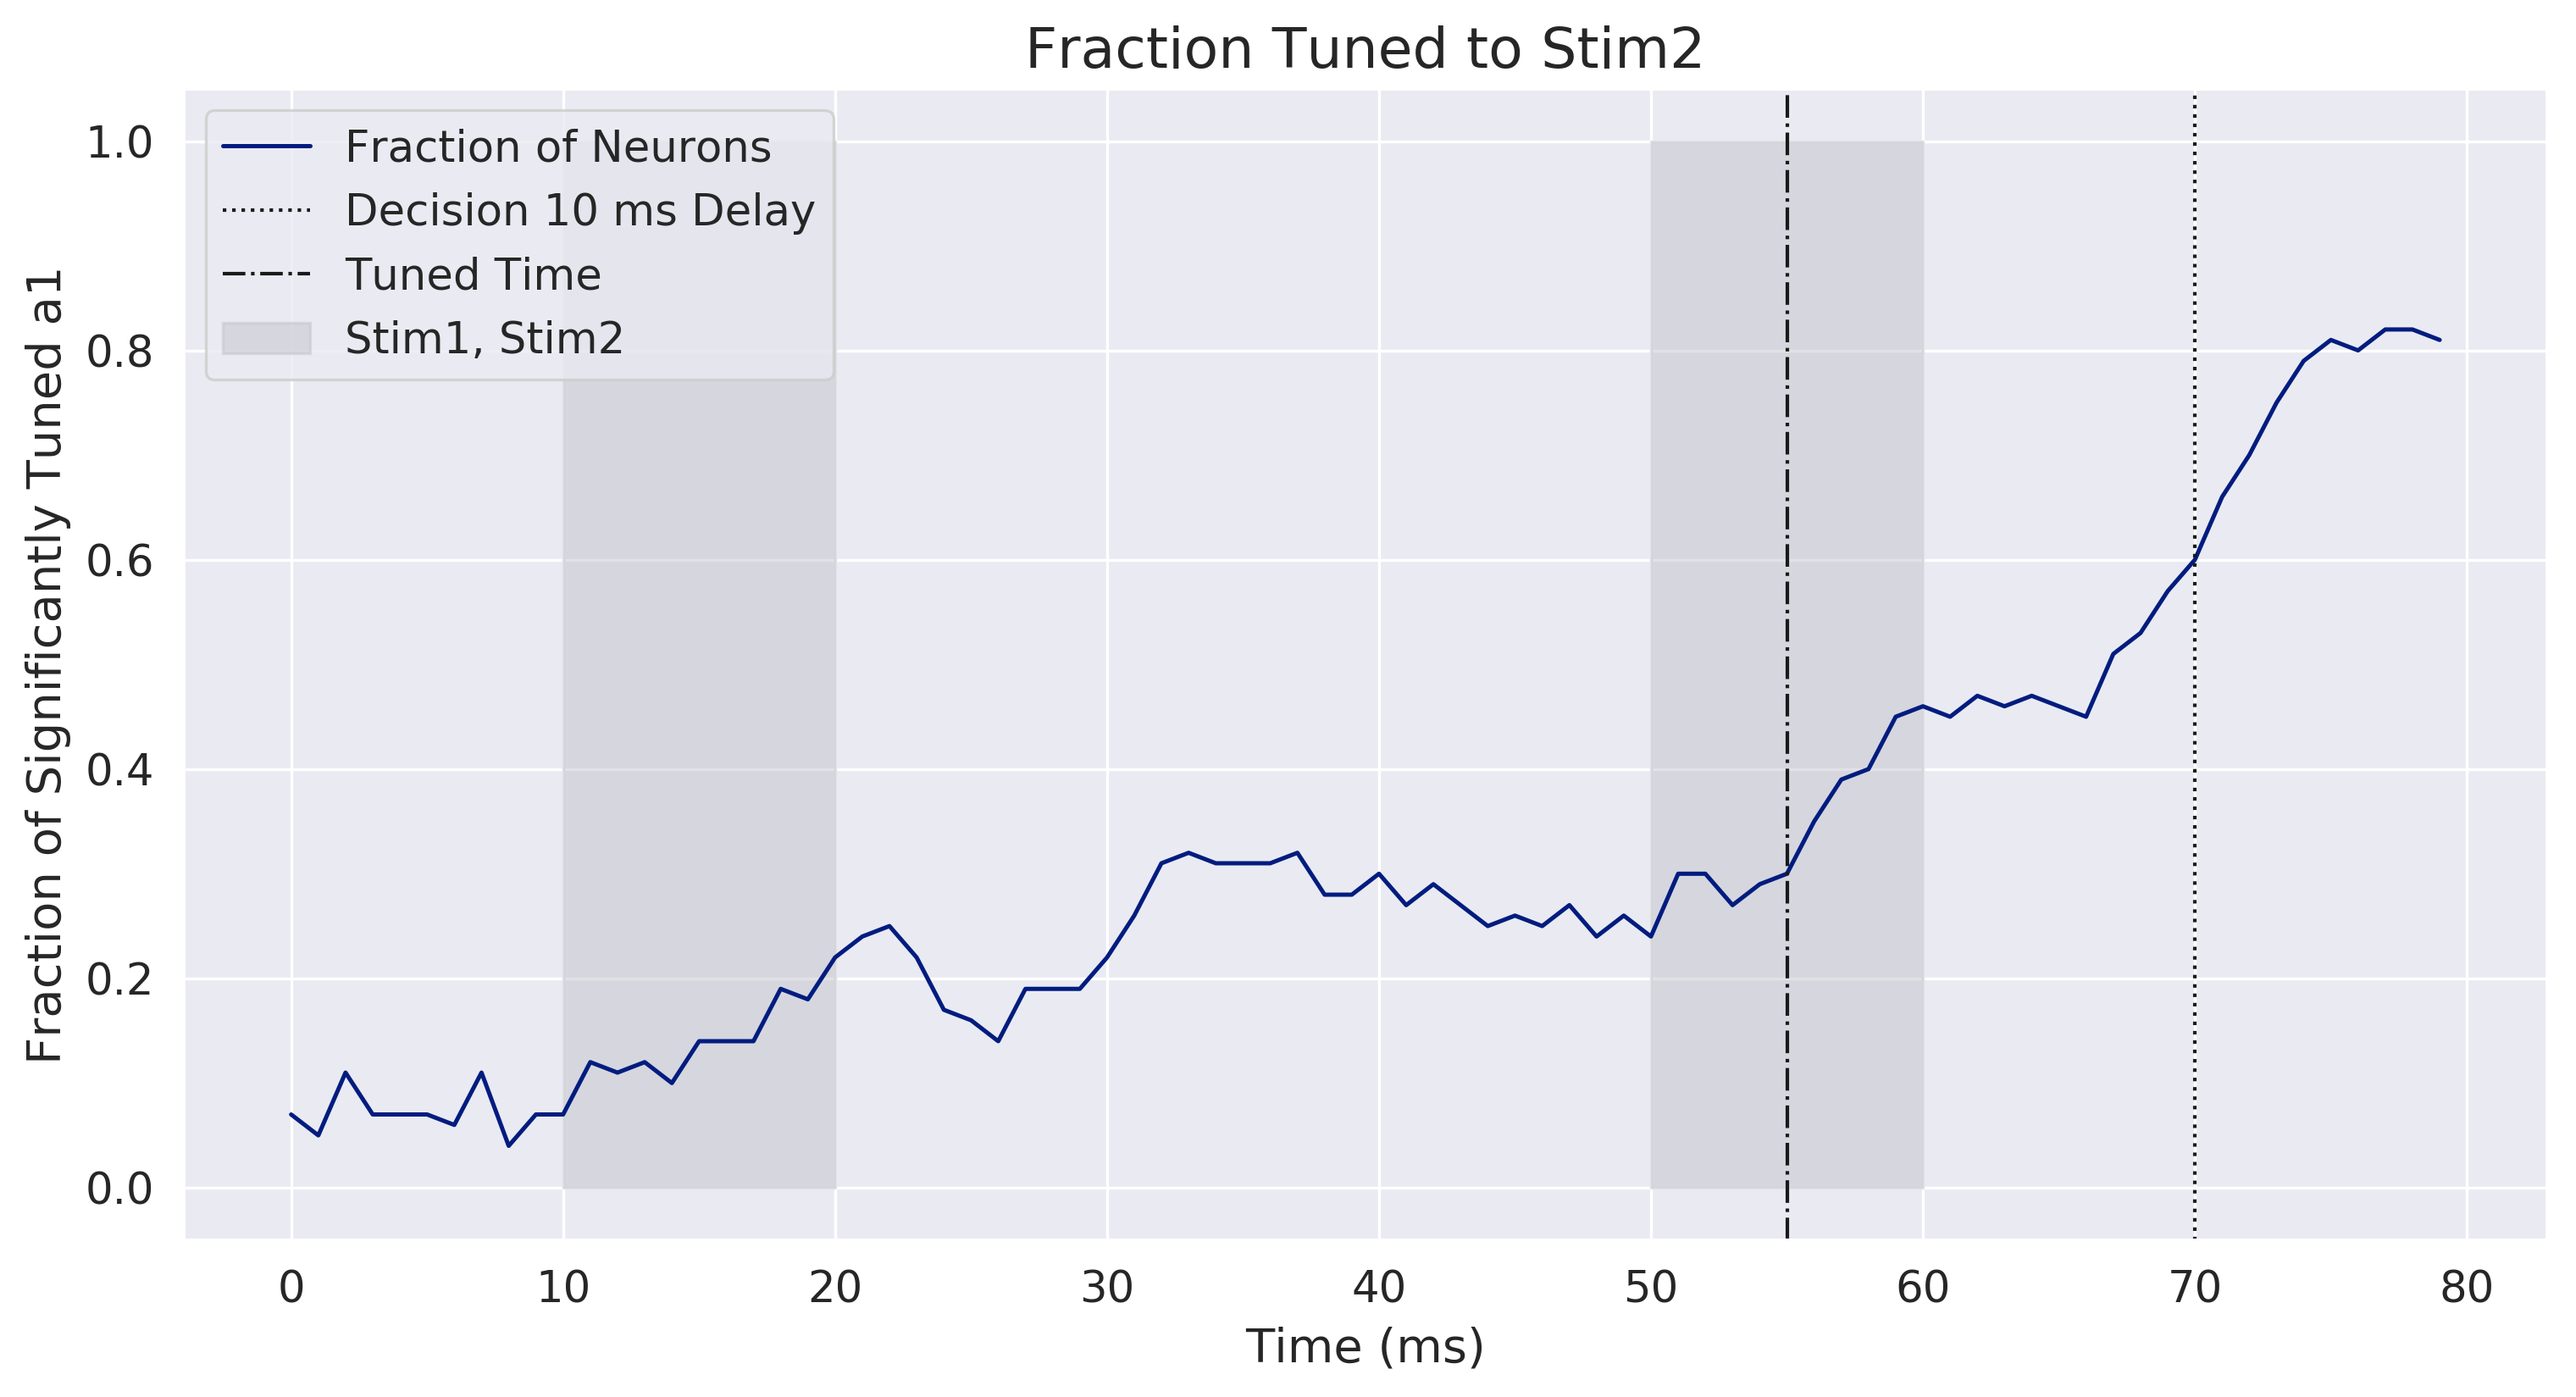

In [590]:
slopes_stim2, frac_tune_stim2 = tuning_calc(rec_freq, xf, rate_network.nb_steps, 100, f_range, 55)
plotting_helper.tuning_percentage(frac_tune_stim2, "Fraction Tuned to Stim2", 10, 50, 10, 70, 55, error=False)

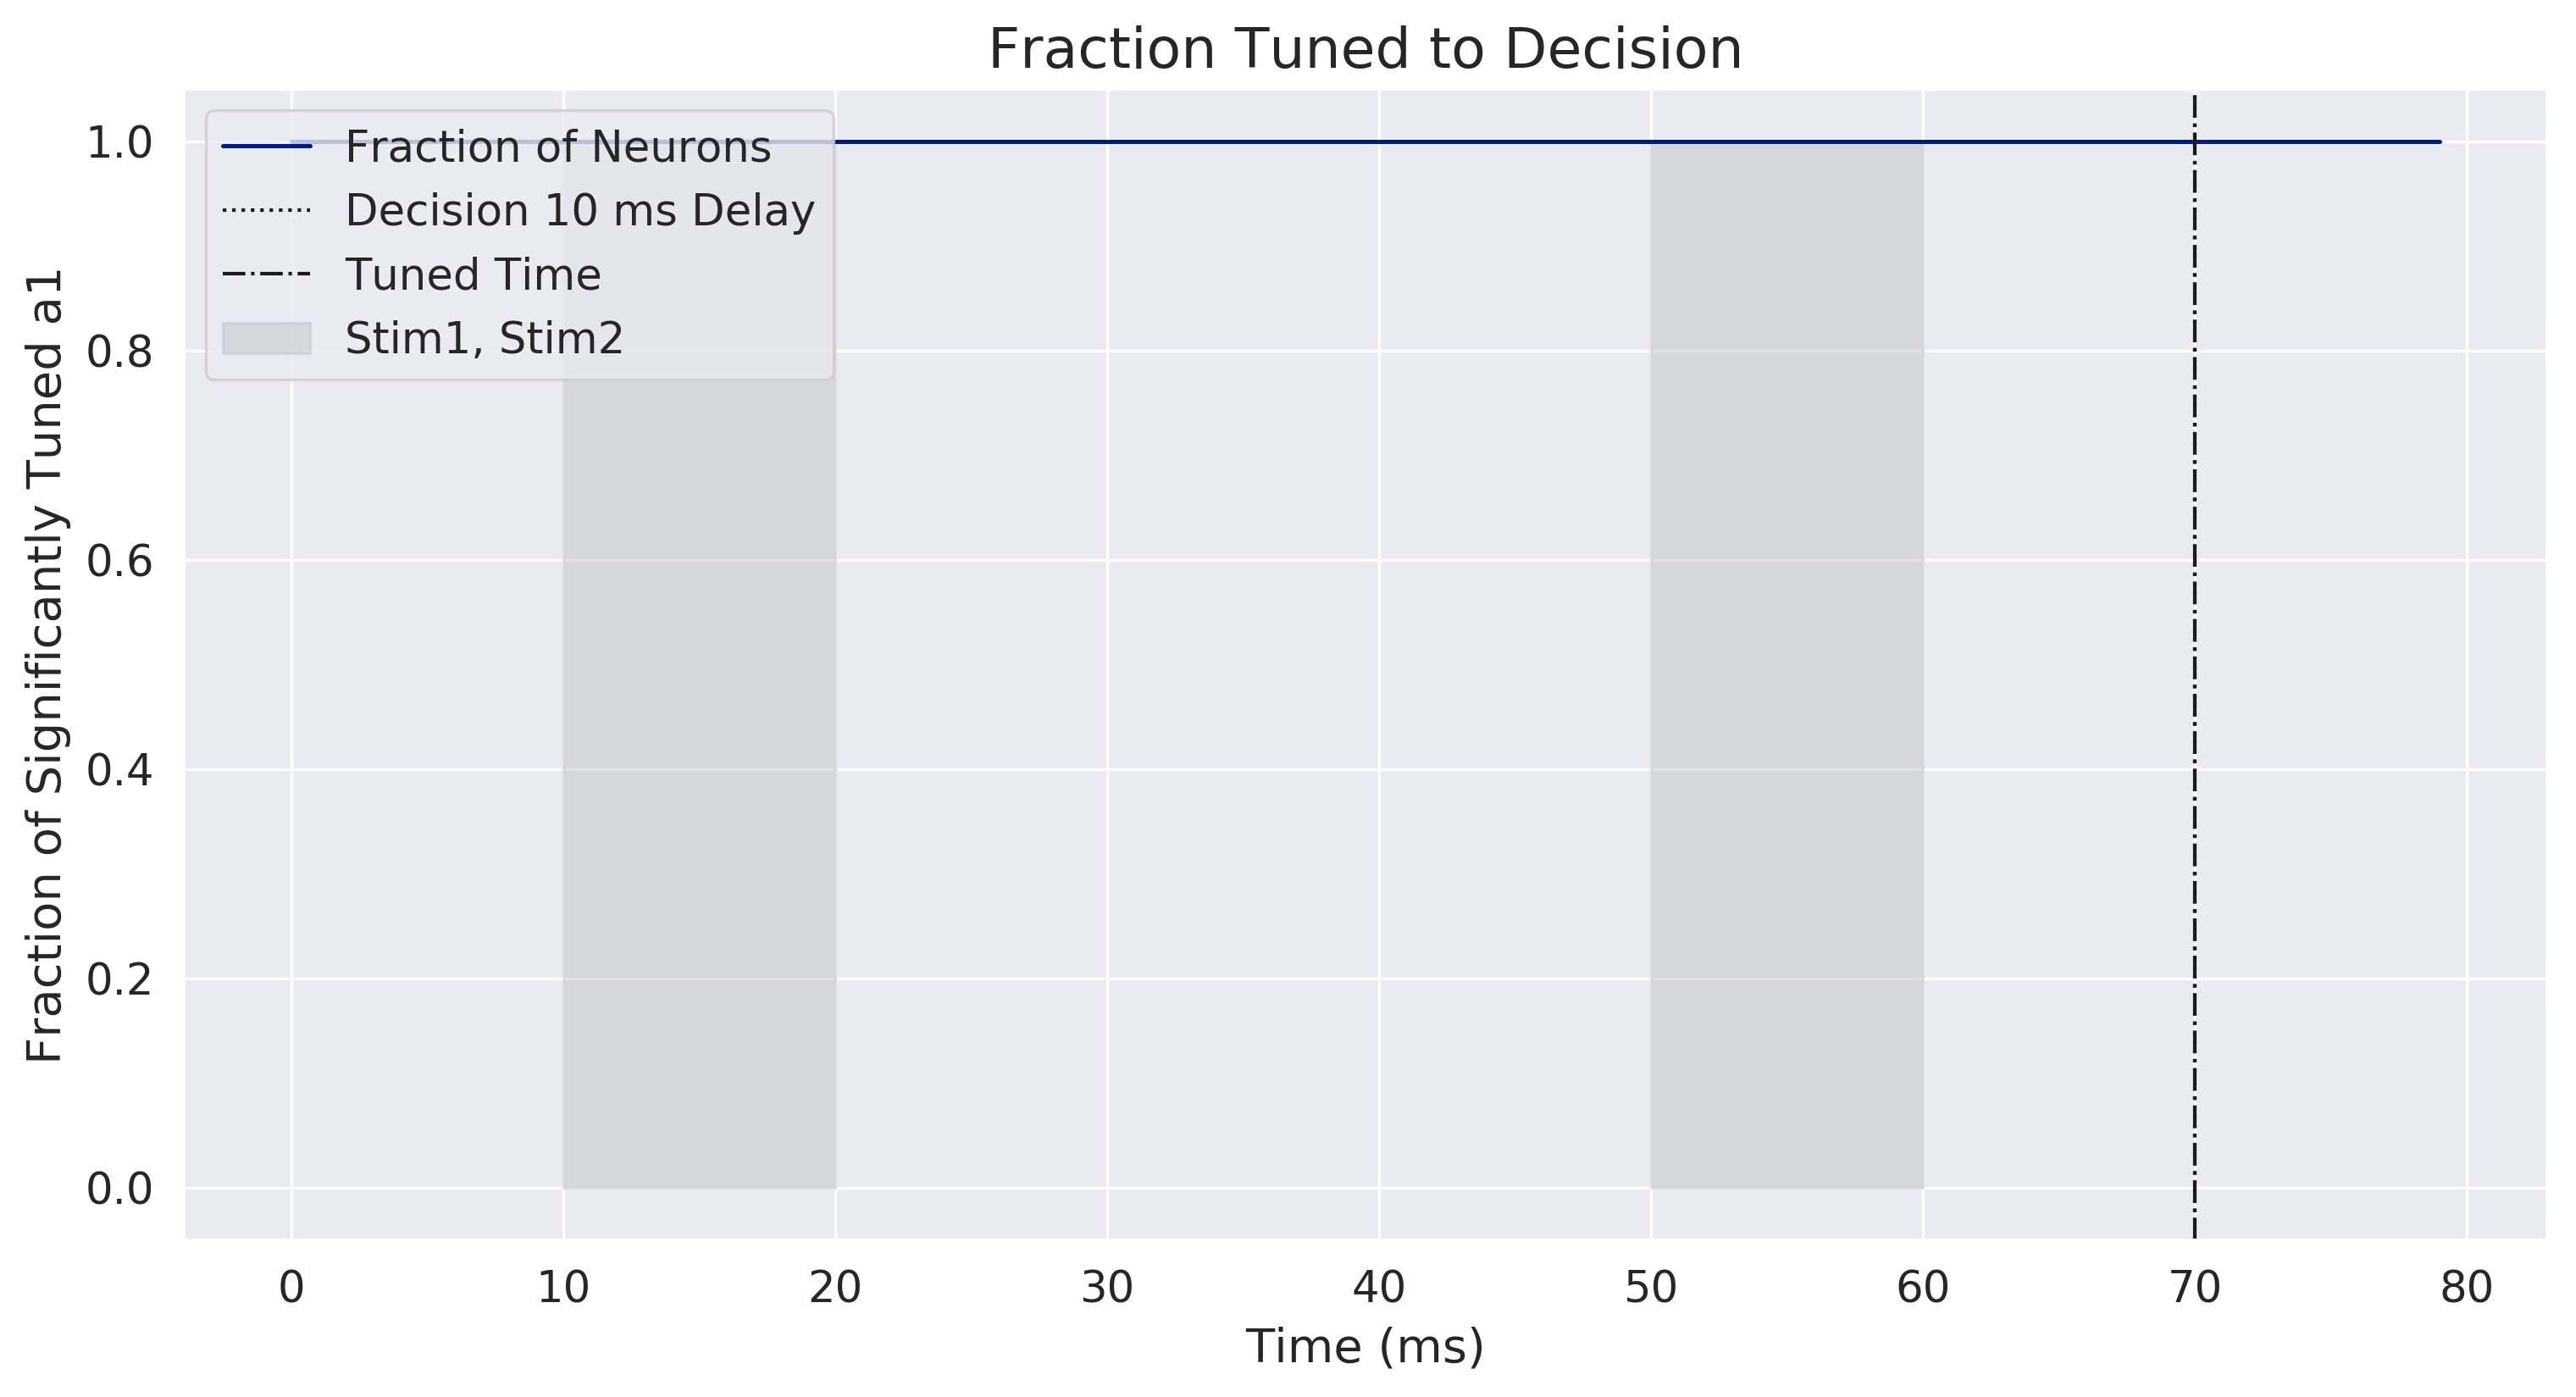

In [591]:
f_dec=np.array((-1,1))
slopes_dec, frac_tune_dec = tuning_calc(rec_freq, yf, rate_network.nb_steps, 100, f_dec, 70)
plotting_helper.tuning_percentage(frac_tune_dec, "Fraction Tuned to Decision", 10, 50, 10, 70, 70, error=False)

In [592]:
tuned_neurons = np.where(slopes[15,:,2]<0.05)[0]
untuned_neurons = np.where(slopes[15,:,2]>0.05)[0]

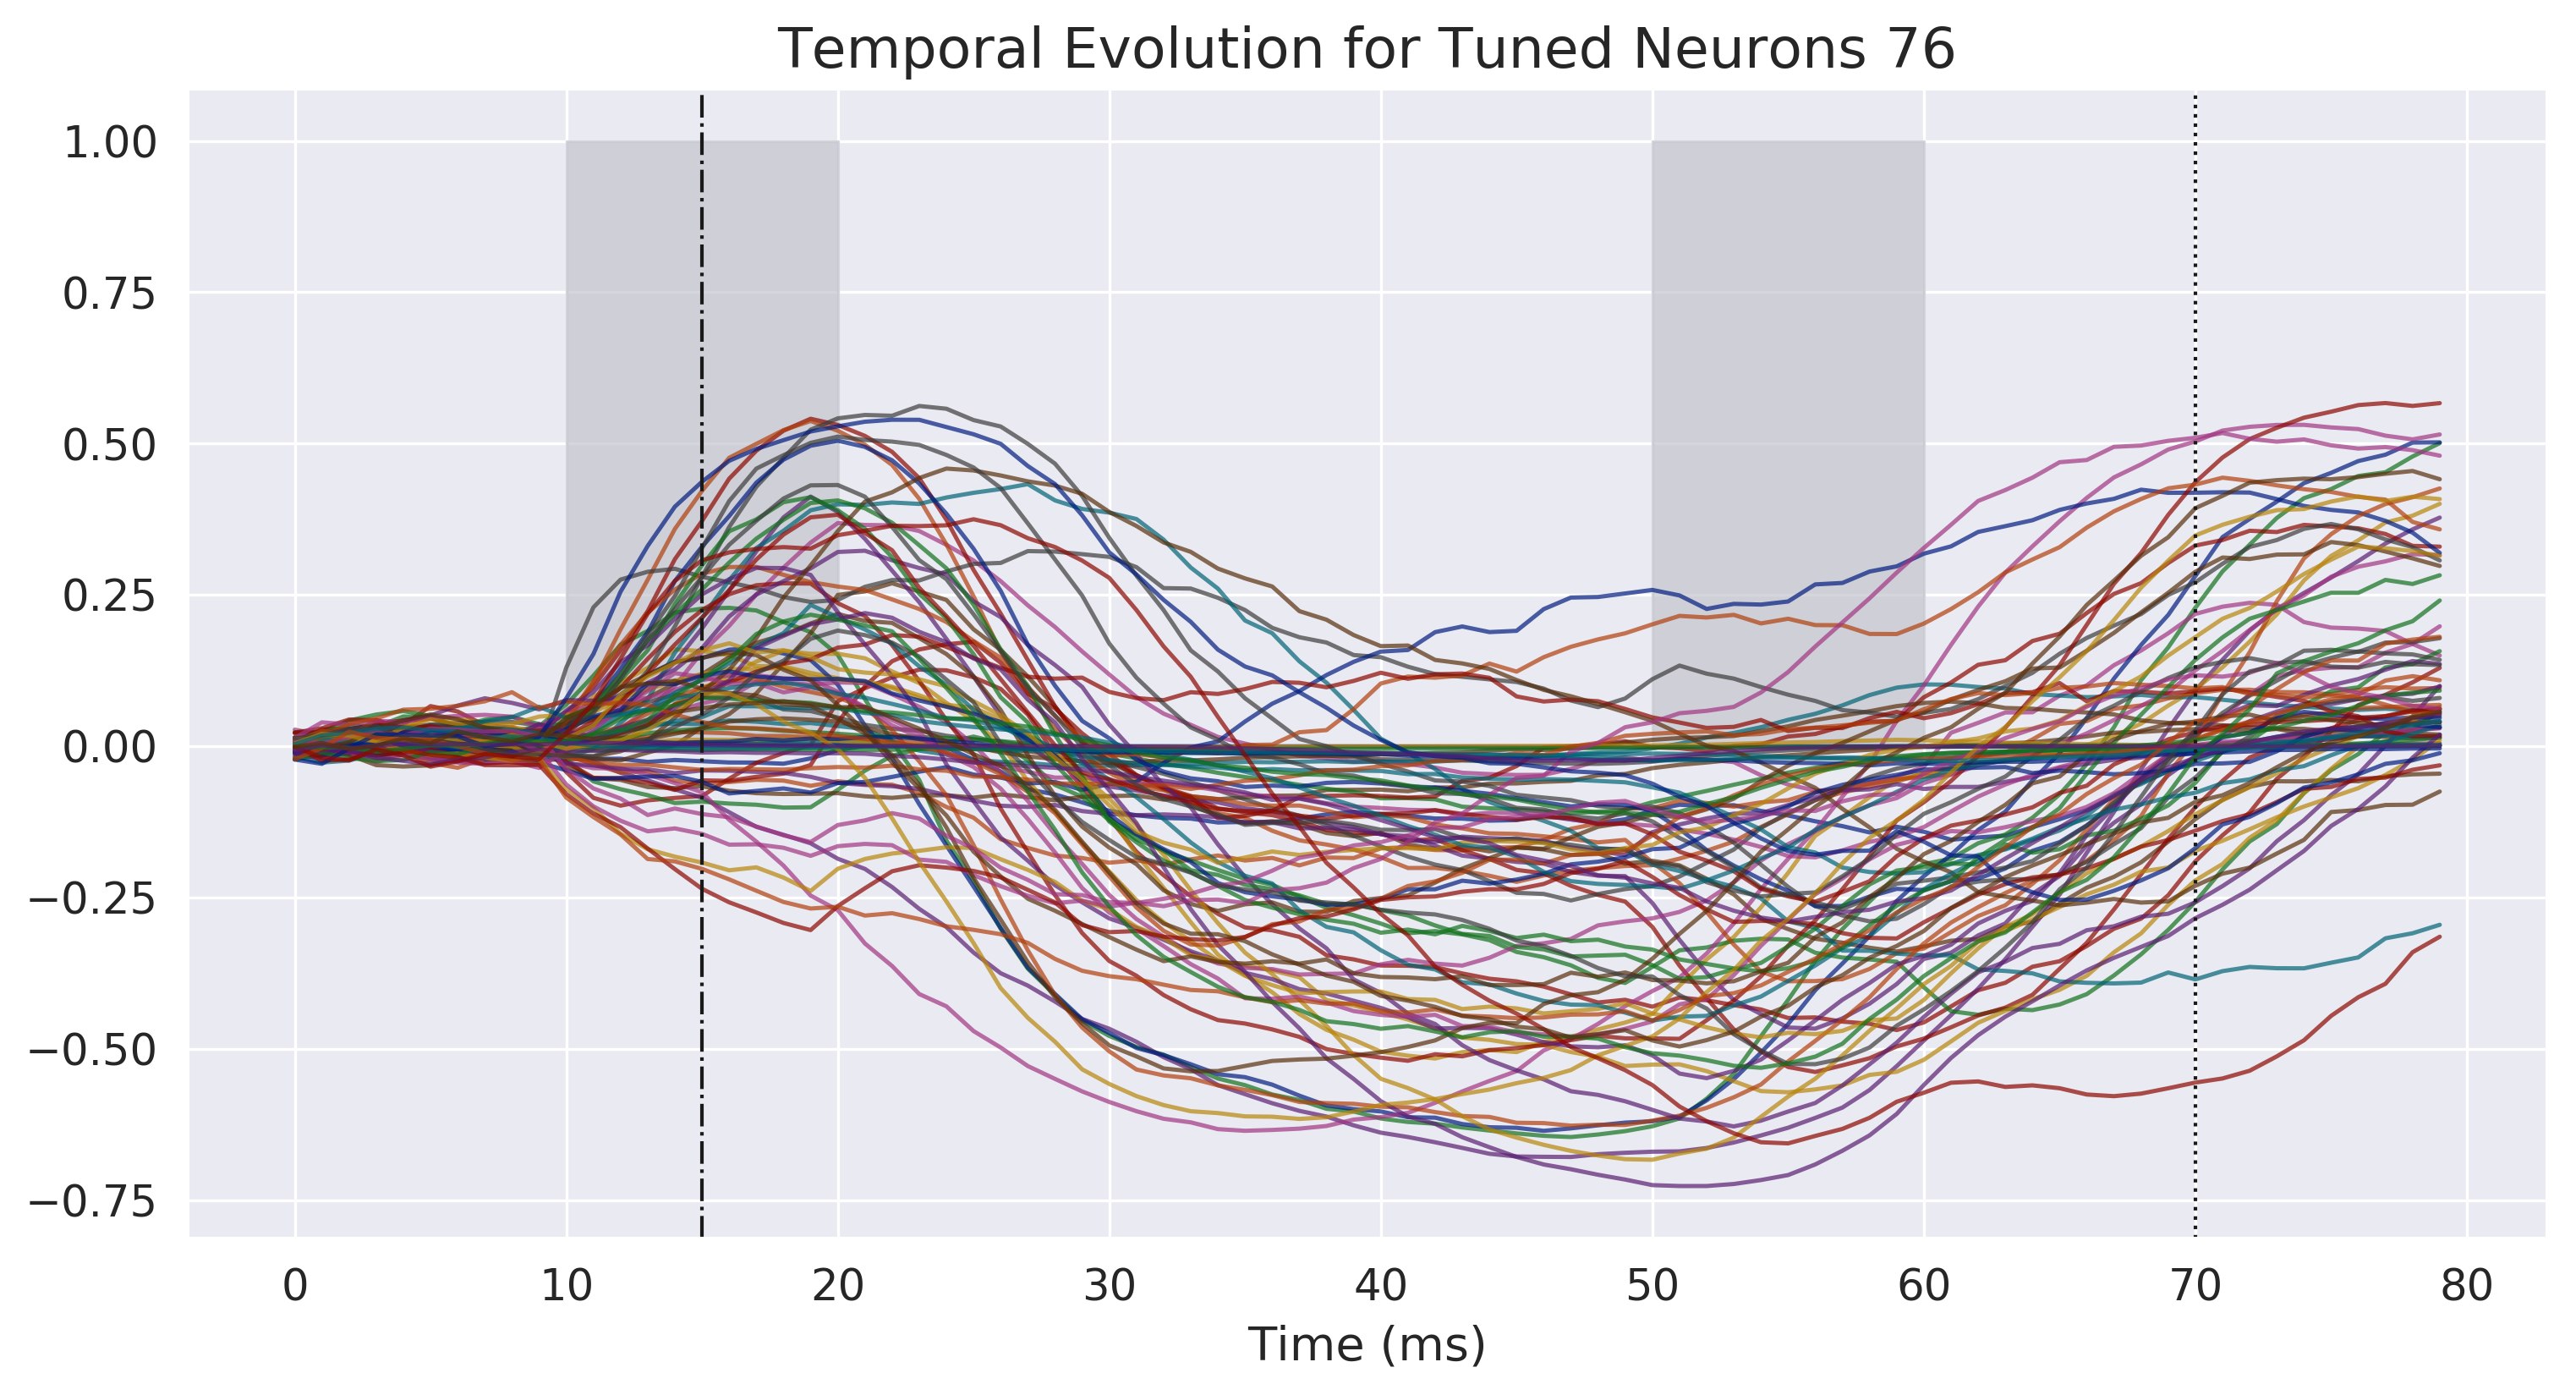

In [593]:
plt.figure(figsize = (12,6), dpi=300)
plt.title("Temporal Evolution for Tuned Neurons %d" %len(tuned_neurons), size=16)
plt.plot(slopes[:,tuned_neurons,0], alpha= 0.7)
plt.fill_between((10,20),(1.0,1.0), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
plt.fill_between((50,60),(1.0,1.0), alpha = 0.7, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
plt.axvline(70, color='k', linestyle=':', linewidth=1, label="Decision 10 ms Delay")
plt.axvline(15, color='k', linestyle='-.', linewidth=1, label="Tuned Time")
plt.xlabel("Time (ms)")
plt.savefig("tuned")
plt.show()

In [564]:
neuron_n = np.array(np.where(slopes[15,tuned_neurons,0] < 0.0)[0])
tn = tuned_neurons[np.array(np.where(slopes[15,tuned_neurons,0] < 0.0)[0])]
neuron_p = np.array(np.where(slopes[15,tuned_neurons,0] > 0.0)[0])
tp = tuned_neurons[np.array(np.where(slopes[15,tuned_neurons,0] > 0.0)[0])]
neuron_pp = tp[np.array(np.where(slopes[55,tuned_neurons[neuron_p],0] > 0.0)[0])]
neuron_pn = tp[np.array(np.where(slopes[55,tuned_neurons[neuron_p],0] < 0.0)[0])]
neuron_np = tn[np.array(np.where(slopes[40,tuned_neurons[neuron_n],0] > 0.0)[0])]
neuron_nn = tn[np.array(np.where(slopes[55,tuned_neurons[neuron_n],0] < 0.0)[0])]

In [725]:
sns.set(context='paper', palette='dark', font_scale=1.0)

In [565]:
rec_activity = rec_freq.detach().numpy()

In [566]:
rec_test[:,:,:].shape

(10, 80, 100)

In [567]:
rec_test = rec_activity[ind,:,:]

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

In [748]:
len(tuned_neurons)

76

In [752]:
len(neuron_nn)/76

0.3157894736842105

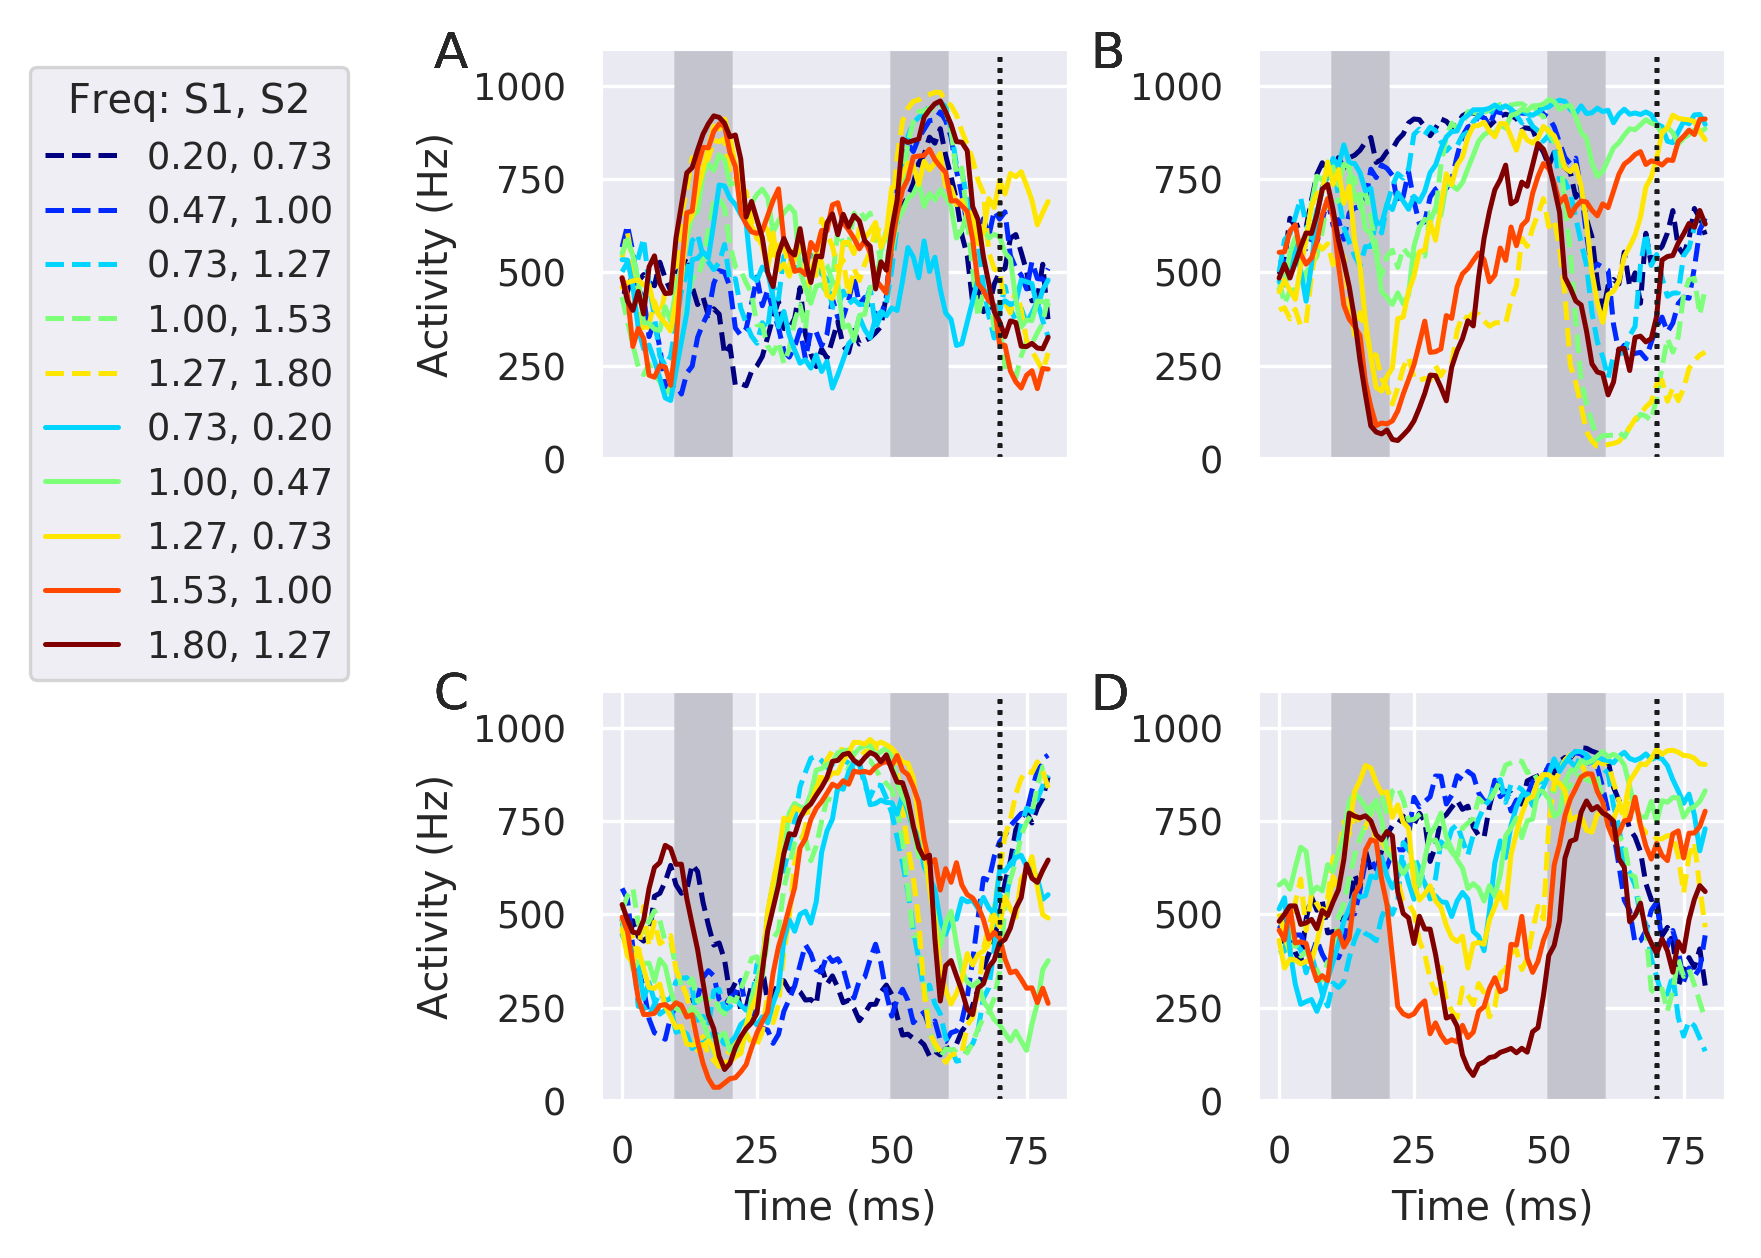

In [872]:
## ind = [0,10,20,30,40,50,60,70,80,90]
f, ax =plt.subplots(2,2, dpi=300)
count=0
for i in range(rec_test.shape[0]-5):
    ax[0,0].plot(rec_test[i,:,neuron_pp[3]]*1000, linestyle="--", c=colors[count],label = "%.2f, %.2f" %(np.round(xf[count*10,15],2),np.round(xf[count*10,55],2)))
    ax[0,0].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,0].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,0].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[0,0].set_ylabel("Activity (Hz)")
    ax[0,1].plot(rec_test[i,:,neuron_nn[4]]*1000, linestyle="--",c=colors[count],label="freq %0.2f" %xf[i,15])
    ax[0,1].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,1].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].set_ylabel("Activity (Hz)")
    ax[0,1].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[1,0].plot(rec_test[i,:,neuron_np[0]]*1000, linestyle="--",c=colors[count],label="freq %0.2f" %xf[i,15])
    ax[1,0].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].set_xlabel("Time (ms)")
    ax[1,0].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[1,1].plot(rec_test[i,:,neuron_pn[0]]*1000, linestyle="--",c=colors[count],label="freq %0.2f" %xf[i,15])
    ax[1,1].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,1].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,1].set_xlabel("Time (ms)")
    ax[1,1].axvline(70, color='k', linestyle=':', linewidth=1)
    count+=1
count2=0
for j in range(rec_test.shape[0]-5):
    #ax[0,0].set_title("%d Tuned Neuron S1 +, S2 +" %len(neuron_pp))
    ax[0,0].text(-35,1050, "A", size=12)
    ax[0,0].plot(rec_test[j+5,:,neuron_pp[3]]*1000, c=colors[count2+2],label = "%.2f, %.2f" %(np.round(xf[(count2+5)*10,15],2),np.round(xf[(count2+5)*10,55],2)))
    ax[0,0].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,0].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,0].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[0,0].set_ylabel("Activity (Hz)")
    ax[0,0].set_ylim(0,1.1*1000)
    ax[0,0].set_xticks([])
    ax[0,1].set_xticks([])
    ax[0,1].set_ylim(0,1.1*1000)
    #ax[0,1].set_title("%d Tuned Neuron S1 -, S2 -" %len(neuron_nn))
    ax[0,1].text(-35,1050,"B", size=12)
    ax[0,1].plot(rec_test[j+5,:,neuron_nn[4]]*1000, c=colors[count2+2],label="freq %0.2f" %xf[i,15])
    ax[0,1].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[0,1].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].set_ylabel("Activity (Hz)")
    ax[1,0].set_ylim(0,1.1*1000)
    
    ax[0,1].axvline(70, color='k', linestyle=':', linewidth=1)
    #ax[1,0].set_title("%d Tuned Neuron S1 -, Delay +" %len(neuron_np))
    ax[1,0].text(-35,1050, "C", size=12)
    ax[1,0].plot(rec_test[j+5,:,neuron_np[0]]*1000, c=colors[count2+2],label="freq %0.2f" %xf[i,15])
    ax[1,0].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,0].set_xlabel("Time (ms)")
    ax[1,0].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[1,0].set_ylim(0,1.1*1000)
    #ax[1,1].set_title("%d Tuned Neuron S1 +, Delay -" %len(neuron_pn))
    ax[1,1].plot(rec_test[j+5,:,neuron_pn[0]]*1000, c=colors[count2+2],label="freq %0.2f" %xf[i,15])
    ax[1,1].fill_between((10,20),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,1].fill_between((50,60),(1100,1100), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    ax[1,1].set_xlabel("Time (ms)")
    ax[1,1].axvline(70, color='k', linestyle=':', linewidth=1)
    ax[1,1].text(-35,1050,"D", size=12)
    ax[1,1].set_ylim(0,1.1*1000)
    count2 +=1
lgd = ax[0,0].legend(title="Freq: S1, S2", bbox_to_anchor=(-0.5,1.0))
plt.tight_layout(pad=0.2, w_pad = 1.4)
plt.savefig("4Neuron Fequency Example", bbox_extra_artists=(lgd,),bbox_inches='tight', format="pdf")
plt.savefig("4Neuron Fequency Example", bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.show()

In [293]:
lgd = plt.legend(bbox_to_anchor = (-0.1,1))
plt.axvline(70, color='k', linestyle='--', linewidth=1, label="decision")
plt.xlabel("Time (ms)")
plt.ylabel("Population Firing Rate (Hz)")
#plt.title("Population activity for stimulus pairs", size = 16)
plt.savefig("Population activity comparison",bbox_extra_artists=(lgd,),

SyntaxError: unexpected EOF while parsing (<ipython-input-293-f284c4a38c63>, line 6)

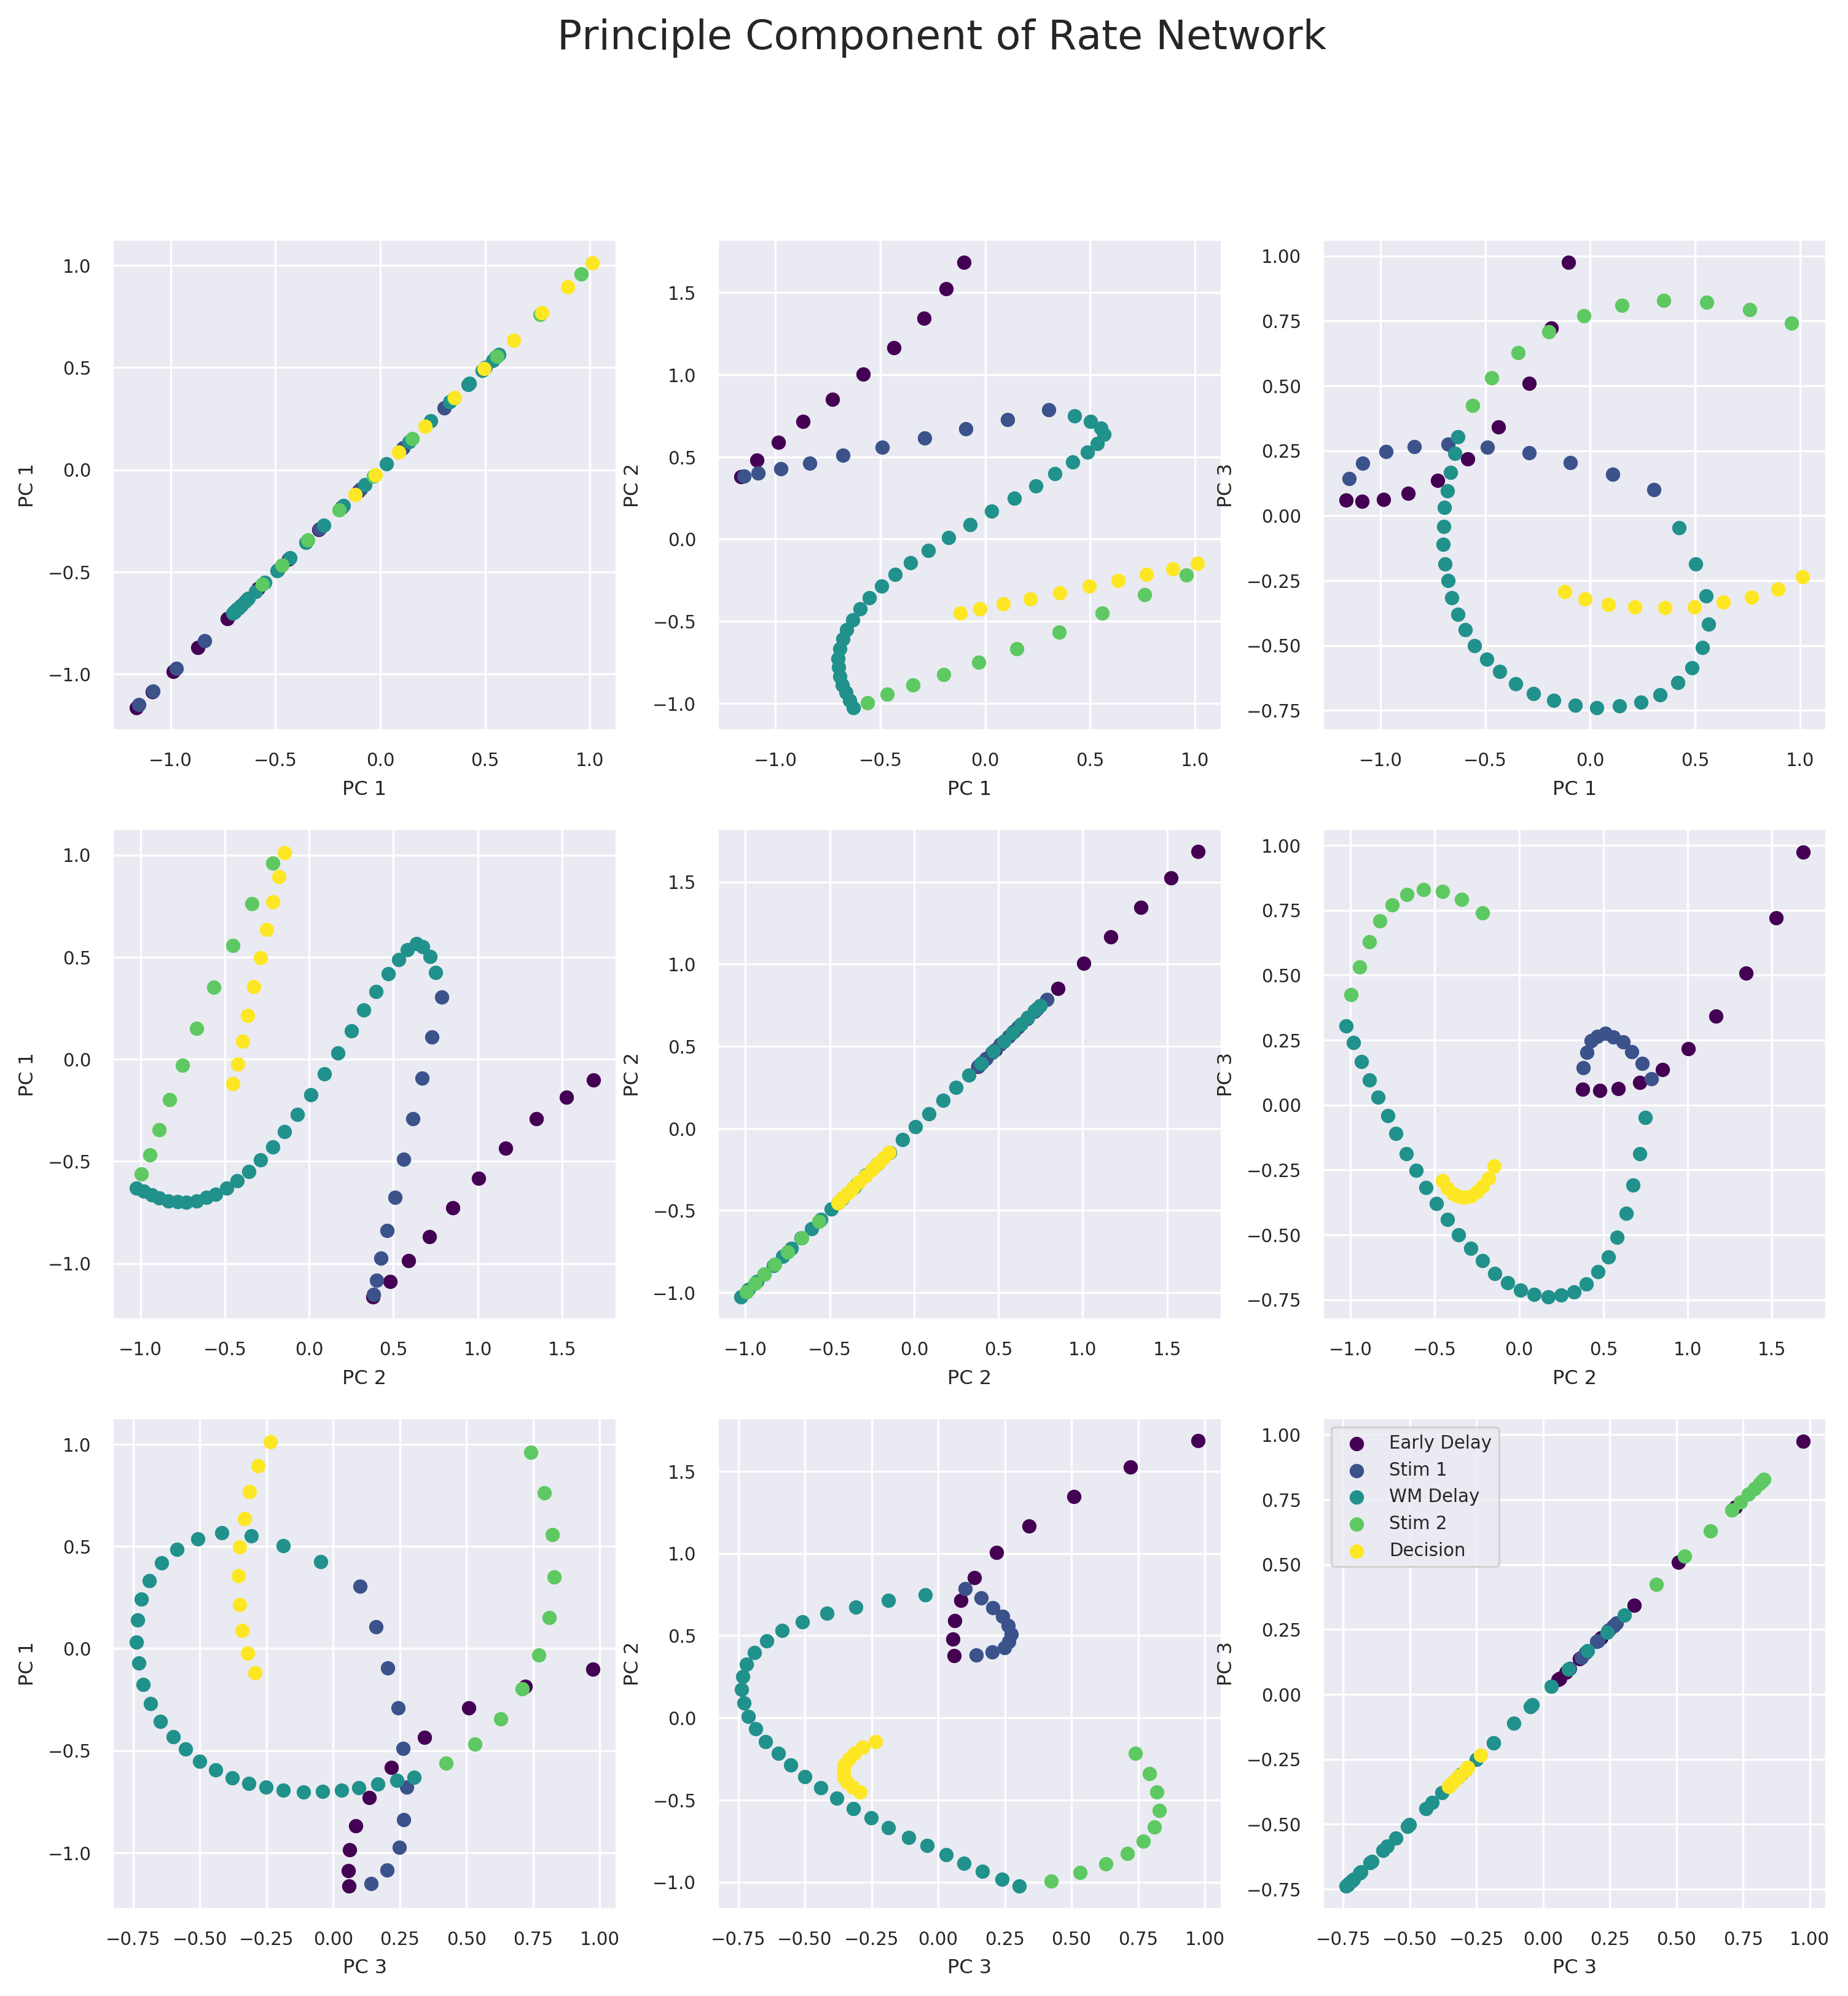

In [294]:
#trials, time, neurons
from sklearn.decomposition import PCA
colors2 = pl.cm.viridis(np.linspace(0,1,5))
fr = rec_activity.mean(0)
pca = PCA(3)
fr_pcs = pca.fit_transform(fr)
pca.explained_variance_ratio_
f, ax = plt.subplots(3,3, figsize = (12,12), dpi=300)

for i in range(3):
    for j in range(3):
        ax[i,j].scatter(fr_pcs[0:10,i], fr_pcs[0:10,j], c=colors2[0], label='Early Delay')
        ax[i,j].scatter(fr_pcs[10:20,i], fr_pcs[10:20,j], c=colors2[1], label = 'Stim 1')
        ax[i,j].scatter(fr_pcs[20:50,i], fr_pcs[20:50,j], c=colors2[2], label = 'WM Delay')
        ax[i,j].scatter(fr_pcs[50:60,i], fr_pcs[50:60,j], c=colors2[3], label = 'Stim 2')
        ax[i,j].scatter(fr_pcs[70:80,i], fr_pcs[70:80,j], c=colors2[4], label = 'Decision')
        ax[i,j].set_xlabel("PC %d" %(i+1))
        ax[i,j].set_ylabel("PC %d" %(j+1))
plt.legend()
plt.suptitle("Principle Component of Rate Network", size=16)
plt.savefig("Rate: pcs on decision")
plt.show()

In [ ]:
w_in_test = rate_network.w_in.detach().numpy()

In [ ]:
w_rec_test = w_rec_dale.detach().numpy()

In [ ]:
pos_in = np.where(w_in_test>0)[1]
neg_in = np.where(w_in_test<0)[1]

In [ ]:
neg_rec = np.where(np.sign(w_rec_test[:,0])<0)
pos_rec = np.where(np.sign(w_rec_test[:,0])>0)

In [ ]:
np.intersect1d(neg_rec,pos_in)

In [ ]:
w_in_test[0,np.intersect1d(neg_rec,pos_in)].sum()

In [ ]:
w_in_test[0,np.intersect1d(pos_rec,neg_in)].sum()

In [675]:
s1_total, s2_total, dec_total = RateRNN.av_tuning_test(rate_network, 15, 55, 70, 100, 300, 0.2, 2e-6)


  0%|          | 0/100 [00:00<?, ?it/s]

1 28.060924530029297



  1%|          | 1/100 [01:17<2:07:24, 77.22s/it]

1 19.1113224029541



  2%|▏         | 2/100 [02:34<2:06:09, 77.24s/it]

1 3.312826633453369



  3%|▎         | 3/100 [03:52<2:05:09, 77.41s/it]

1 13.141195297241211



  4%|▍         | 4/100 [05:10<2:04:18, 77.70s/it]

1 11.464478492736816



  5%|▌         | 5/100 [06:28<2:03:17, 77.87s/it]

1 3.9592695236206055



  6%|▌         | 6/100 [07:46<2:01:58, 77.86s/it]

1 11.053695678710938



  7%|▋         | 7/100 [09:07<2:02:11, 78.84s/it]

1 8.706185340881348



  8%|▊         | 8/100 [10:24<1:59:46, 78.12s/it]

1 1.4636462926864624



  9%|▉         | 9/100 [11:40<1:57:37, 77.56s/it]

1 18.49959373474121



 10%|█         | 10/100 [12:57<1:56:14, 77.50s/it]

1 2.4885196685791016



 11%|█         | 11/100 [14:14<1:54:40, 77.31s/it]

1 18.20256996154785



 12%|█▏        | 12/100 [15:32<1:53:23, 77.31s/it]

1 12.29804515838623



 13%|█▎        | 13/100 [16:49<1:52:07, 77.33s/it]

1 1.1036672592163086



 14%|█▍        | 14/100 [18:06<1:50:35, 77.16s/it]

1 8.94775676727295



 15%|█▌        | 15/100 [19:23<1:49:15, 77.12s/it]

1 2.2209627628326416



 16%|█▌        | 16/100 [20:41<1:48:31, 77.52s/it]

1 27.53488540649414


KeyboardInterrupt: 

In [741]:
def tuning_percentage(frac_sig_tuned, title, s1,s2,dur, dec_time, tune_time, error):
    plt.figure(dpi=300)
    #plt.title(title, size=16)
    if error==True:
        std = [frac_sig_tuned.mean(0) - np.std(frac_sig_tuned, axis=0), frac_sig_tuned.mean(0)+np.std(frac_sig_tuned, axis=0)]
        plt.fill_between(np.linspace(0,80,80), std[0],std[1], alpha=0.2)
        plt.plot(frac_sig_tuned.mean(0), label="Fraction of Neurons")
    else:
        plt.plot(frac_sig_tuned, label="Fraction of Neurons")
    plt.fill_between((s1,s1+dur),(1.0,1.0), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True, label="S1, S2")
    plt.fill_between((s2,s2+dur),(1.0,1.0), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
    #plt.axvline(dec_time, color='k', linestyle=':', linewidth=1, label="Decision Cue")
    plt.axvline(tune_time, color='k', linestyle='-.', linewidth=1, label="Tuned Time")
    plt.legend(loc=0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Frac. Sign. a1")
    plt.ylim(0,1)
    plt.xlim(0,60)
    plt.savefig(title, format="pdf")
    plt.show()

In [873]:
tuning_percentage(s1_total, "Average 100 Networks: Fraction Tuned to Stim1", 10, 50, 10, 70, 15, error=True)

NameError: name 's1_total' is not defined

In [740]:
tuning_percentage(s2_total, "Average 100 Networks: Fraction Tuned to Stim2", 10, 50, 10, 70, 55, error=True)

NameError: name 's2_total' is not defined

In [ ]:
plotting_helper.tuning_percentage(dec_total, "Average 100 Networks: Fraction Tuned to dec", 10, 50, 10, 70, 70, error=True)

In [596]:
cc_stim = np.empty(rate_network.nb_steps-15)
cc_md = np.empty(rate_network.nb_steps-15)
for i in range(rate_network.nb_steps-15):
    cc_stim[i] = pearsonr(slopes[15,:,0],slopes[i+15,:,0])[0]
    cc_md[i] = pearsonr(slopes[35,:,0],slopes[i+15,:,0])[0]

In [597]:
t = np.linspace(0,80,80)
cc_stim_adj = np.hstack((-1*np.ones(15),cc_stim))
cc_md_adj = np.hstack((-1*np.ones(15),cc_md))

In [598]:
sns.set(context='paper', palette='dark', font_scale=0.6)

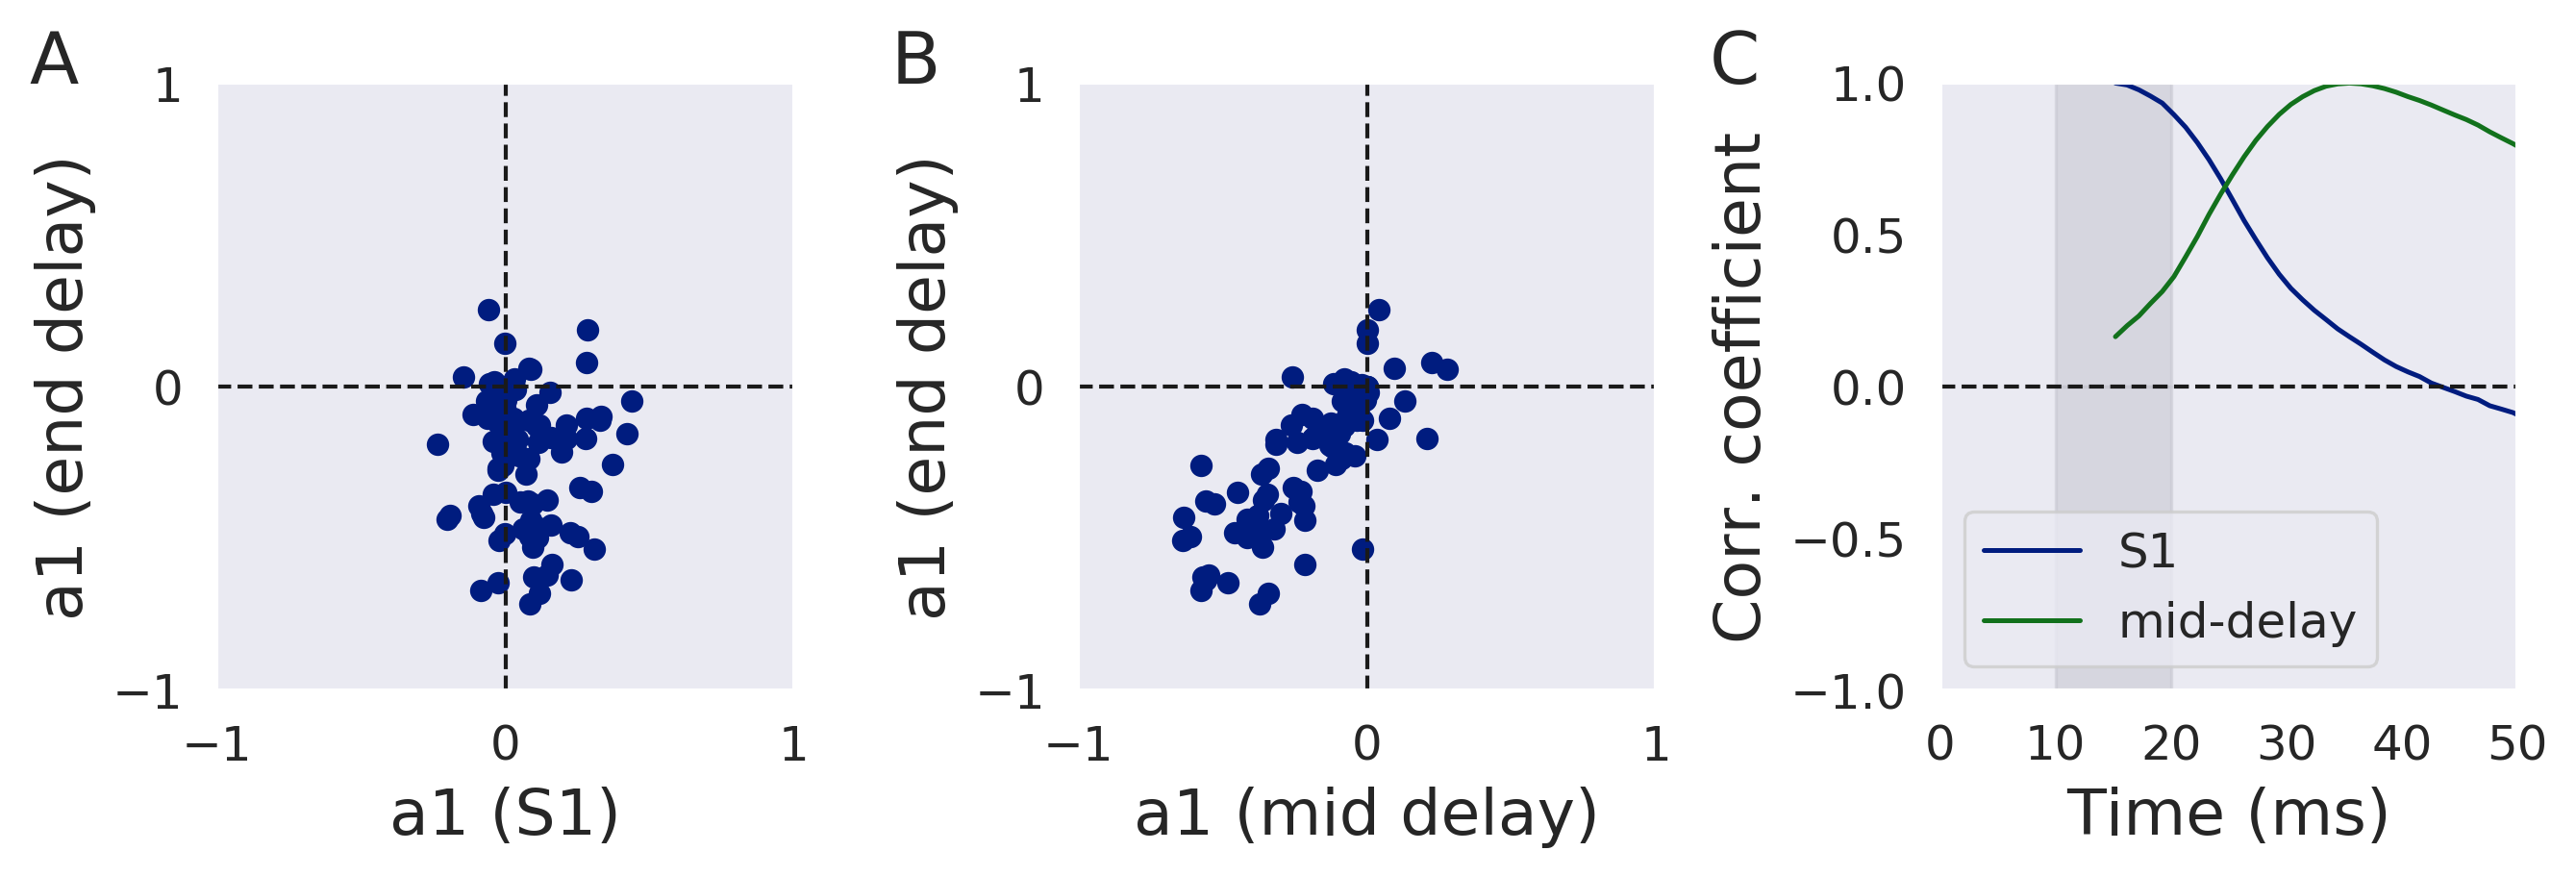

In [845]:
f, ax = plt.subplots(1,3,figsize=(9,3), dpi=300)

#ax[2].set_xticklabels(labels)
#plt.suptitle("Consistancy of Frequency Tuning", size=14)
ax[0].scatter(slopes[15,:,0], slopes[49,:,0])
ax[0].axvline(0, color='k', linestyle='--', linewidth=1)
ax[0].axhline(0, color='k', linestyle='--', linewidth=1)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_yticks([-1,0,1])
ax[0].set_xticks([-1,0,1])
ax[0].set_xlabel("a1 (S1)", size=16)
ax[0].set_ylabel("a1 (end delay)", size=16)
ax[0].grid(False)
ax[0].tick_params(labelsize=12)
ax[0].text(-1.65,1.0,"A", size=18)
ax[1].scatter(slopes[35,:,0], slopes[49,:,0])
ax[1].axvline(0, color='k', linestyle='--', linewidth=1)
ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
ax[1].set_xlabel("a1 (mid delay)", size=16)
ax[1].set_ylabel("a1 (end delay)", size=16)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].set_yticks([-1,0,1])
ax[1].set_xticks([-1,0,1])
ax[1].tick_params(labelsize=12)
ax[1].grid(False)
ax[1].text(-1.65,1.0,"B", size=18)
ax[2].plot(t[15:80], cc_stim_adj[15:80], label= "S1")
ax[2].plot(t[15:80], cc_md_adj[15:80], c="g", label = "mid-delay")
ax[2].axhline(0, color='k', linestyle='--', linewidth=1)
ax[2].fill_between((10,20),(1,1), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
ax[2].fill_between((10,20),(-1,-1), alpha = 0.5, edgecolor='#c4c4ce', facecolor ='#c4c4ce', interpolate=True)
ax[2].set_xlabel("Time (ms)", size=16)
ax[2].tick_params(labelsize=12)
ax[2].set_ylabel("Corr. coefficient", size=16)
ax[2].grid(False)
ax[2].set_ylim(-1,1)
ax[2].set_xlim(0,50)
ax[2].legend(prop={'size': 12})
ax[2].set_xticks([0,10,20,30,40,50])
ax[2].set_yticks([-1,-0.5,0,0.5,1])
ax[2].text(-20,1.0,"C", size=18)
plt.tight_layout()
plt.savefig("Consistany of frequency tuning", format='pdf')
plt.savefig("Consistany of frequency tuning")
plt.show()

In [ ]:
rate_network.w_in

In [108]:
x=np.linspace(-1,1,10000)

def heavy(x):
    y=np.empty(len(x))
    for i,j in enumerate(x):
        if j<0:
            y[i]=0
        else:
            y[i]=1
    return y

In [109]:
1/(100*x+1)**2

array([1.02030405e-04, 1.02071646e-04, 1.02112912e-04, ...,
       9.81073061e-05, 9.80684440e-05, 9.80296049e-05])

In [110]:
heavy(x)

array([0., 0., 0., ..., 1., 1., 1.])

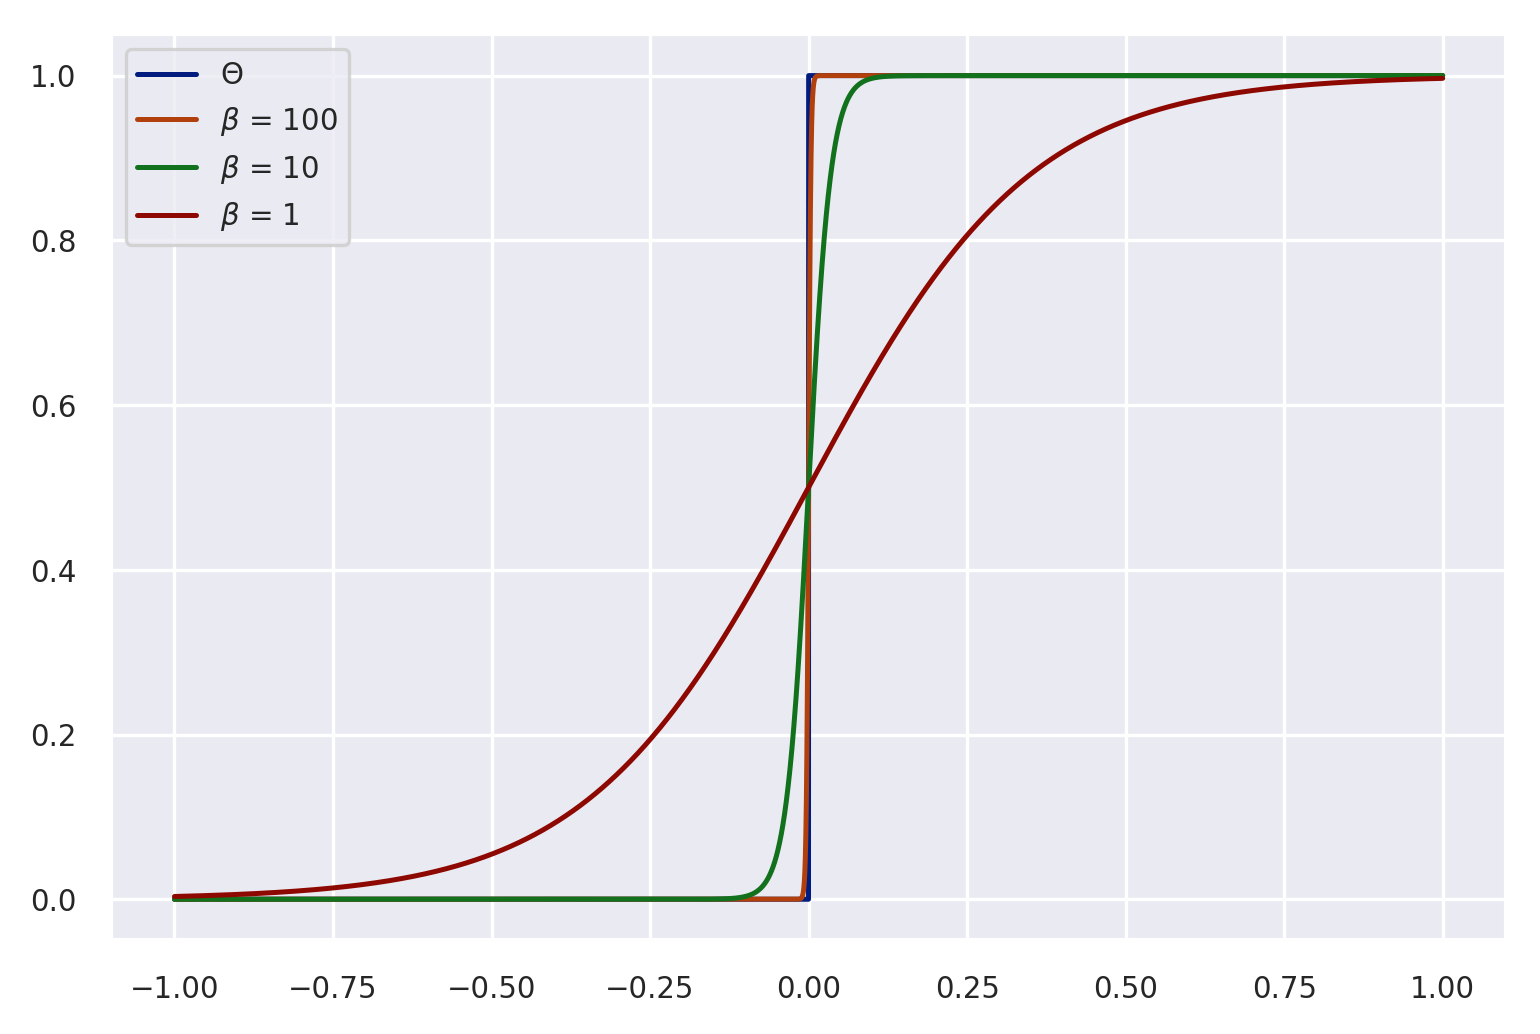

In [111]:
plt.figure(dpi=300)
plt.plot(x, heavy(x), label = r'$\Theta$')
plt.plot(x,1/(1+e**(-x*100)), label=r'$\beta$ = %d' %100)
plt.plot(x,1/(1+e**(-x*10)), label=r'$\beta$ = %d' %10)
plt.plot(x,1/(1+e**(-x)), label=r'$\beta$ = %d' %1)
plt.legend()
plt.show()

In [127]:
sns.set(context='paper', palette='dark', font_scale=1.0)

ValueError: x and y can be no greater than 2-D, but have shapes (60, 80, 1) and (60, 80, 1)

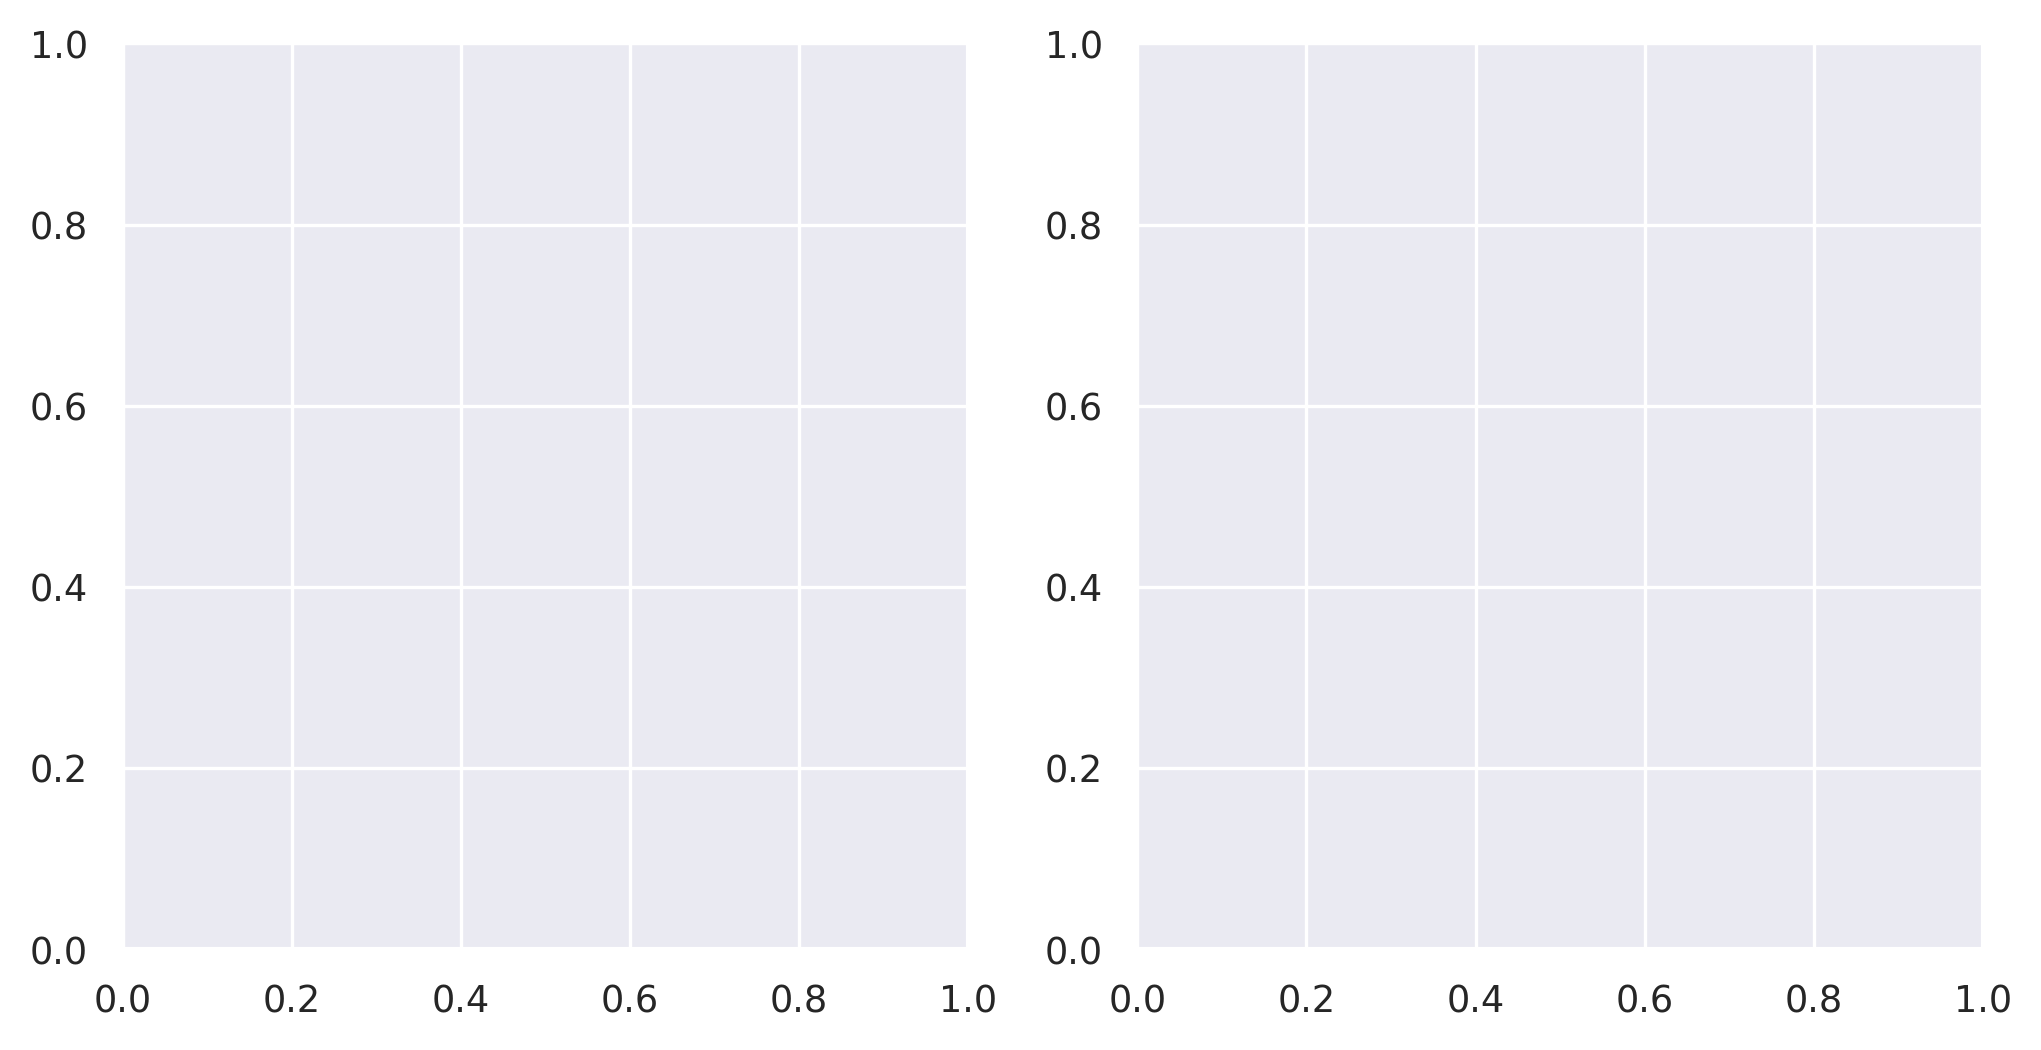

In [846]:
f, ax = plt. subplots(1,2, figsize=(8,4), dpi = 300)
ax[0].plot(x,1/(1+e**(-x*100)), label=r'$\beta$ = %d' %100)
ax[0].plot(x,1/(1+e**(-x*10)), label=r'$\beta$ = %d' %10)
ax[0].plot(x,1/(1+e**(-x)), label=r'$\beta$ = %d' %1)
ax[0].plot(x, heavy(x), label = r'$\Theta$(x)')
ax[0].set_xlabel("x")
ax[0].set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax[0].legend()
ax[0].set_ylabel(r'$\sigma$(x)')
ax[1].set_ylabel(r'$\sigma^\prime$(x)')
ax[1].plot(x,1/(100*np.abs(x)+1.0)**2, label=r'$\beta$ = %d' %100)
ax[1].plot(x,1/(10*np.abs(x)+1.0)**2, label= r'$\beta$ = %d' %10)
ax[1].plot(x,1/(1*np.abs(x)+1.0)**2, label= r'$\beta$ = %d' %1)
ax[1].set_xlim(-1,0.003)
#ax[1].set_xticks([-1.0, -0.75, -0.5, -0.25, 0])
ax[1].set_xlabel("x")
ax[1].legend()
plt.tight_layout()
plt.savefig("surrogate", format='pdf')
plt.savefig("surrogate")
plt.show()

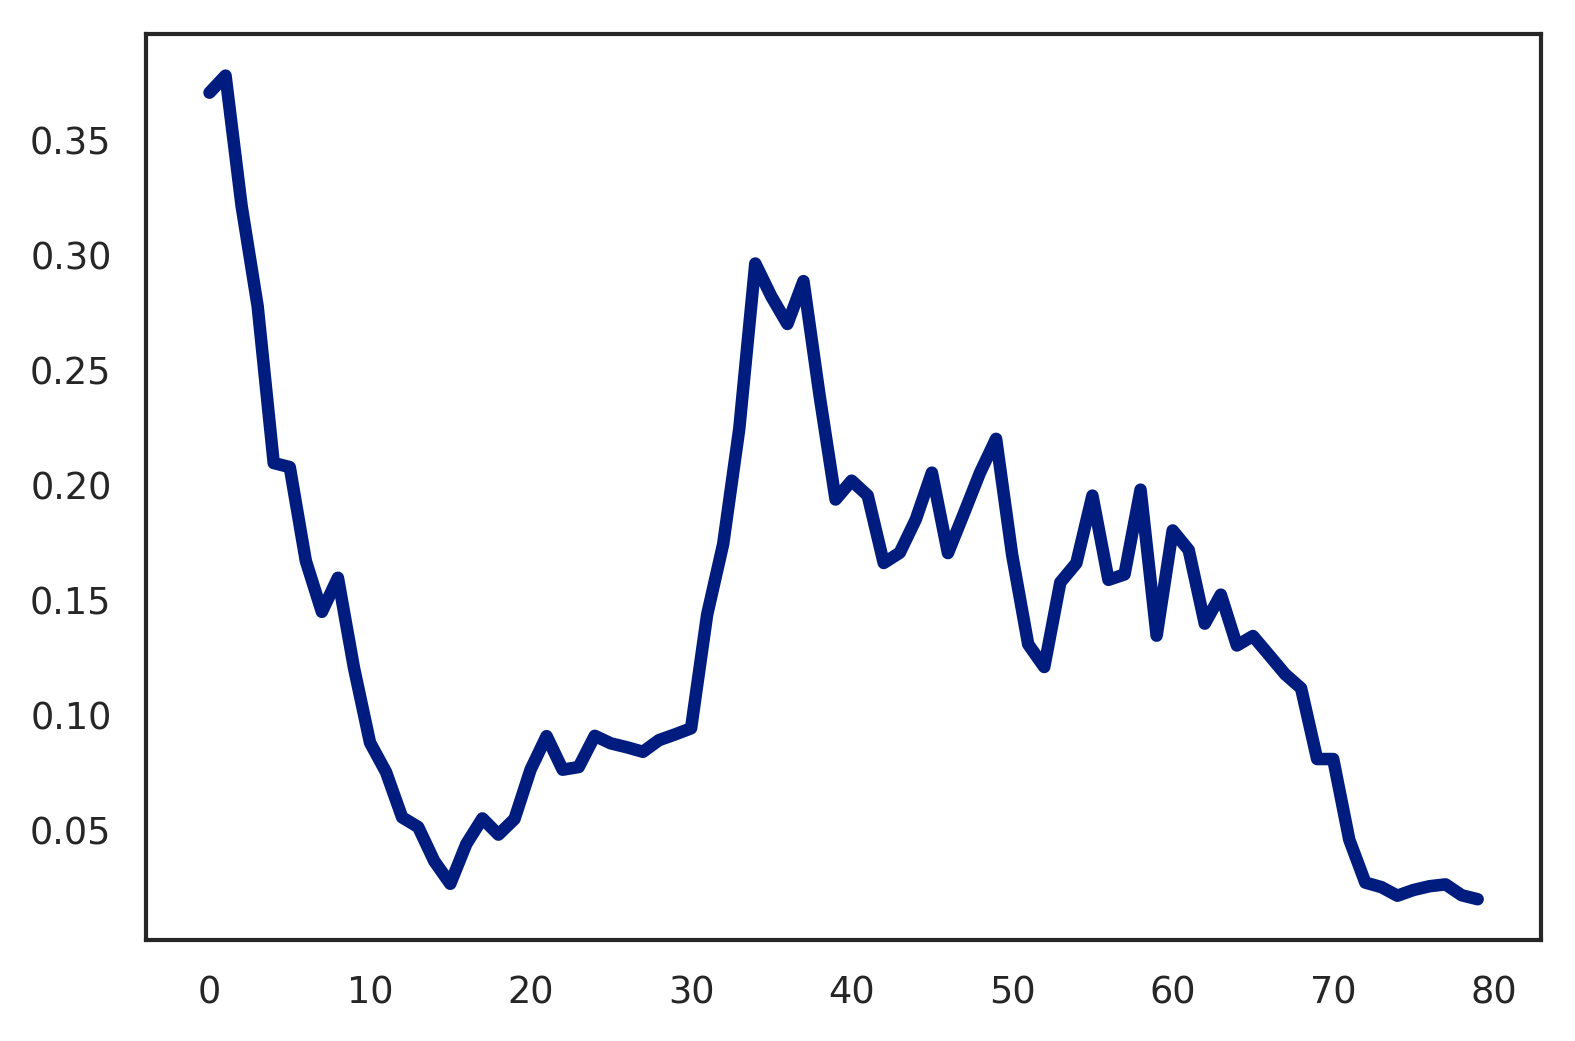

In [874]:
plt.figure(dpi=300)
sns.set_style("white")
plt.plot(rec_freq.detach().numpy()[0,:,1], linewidth=3)
plt.grid(False)
plt.savefig("rate_test")
plt.show()

In [133]:
data_recorded = pd.read_pickle('ra')

FileNotFoundError: [Errno 2] No such file or directory: 'rate_weights.pkl'